# **Implementing a notebook**

In [1]:
import numpy as np
import pandas as pd
import random
from copy import deepcopy

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
import matplotlib
import matplotlib.pyplot as plt

In [4]:
random.seed(42)
np.random.seed(42)

In [5]:
deb = print

In [6]:
class FullyConnected():
    layer_count = 0
    def __init__(self, out_features = 100, in_features = 100):
        '''
            Fully Connected layer
            out_features: No of Output Features
            no_of_inp_featues: No of Input Features
        '''
        self.out_features = out_features
        self.in_features = in_features
        self.weight = np.random.normal(loc=0.0, scale=1/np.sqrt(self.out_features), size=(self.out_features, self.in_features))
        self.bias = np.zeros((self.out_features, 1), dtype=np.float32)
        self.weight_grad = None
        self.bias_grad = None
        self.layer_id = FullyConnected.layer_count
        FullyConnected.layer_count += 1
    
    def __str__(self, ):
        return 'Fully Connected Layer ID = {}: (In:{}, Out:{})'.format(self.layer_id, self.in_features, self.out_features)
    
    def forward(self, x):
        '''
            x: Input (N, F_in) where N = No. of samples, F_in: No. of input features
            
            returns:
                Wx + B (N, F_out) where W, B are trainable weight and bias where N: No. of samples, F_out Output dimension/features.
        '''
        assert x.shape[1] == self.in_features, "Input dimension Mismatch"
        wx = np.matmul(self.weight, np.transpose(x, (1, 0)))
        wx_plus_b = np.add(wx, self.bias)
        return np.transpose(wx_plus_b, (1, 0))
    
    def backward(self, y_grad, y, x):
        '''
            y_grad: Gradiant of output (N, F_out)
            y: Output of layer (N, F_out)
            x: input of layer (N, F_in)
        '''
        grad_x = np.matmul(y_grad, self.weight)
        
        weight_grad = np.matmul(np.transpose(y_grad, (1, 0)), x)
        if self.weight_grad is not None:
          self.weight_grad += weight_grad
        else:
          self.weight_grad = weight_grad
        assert y_grad.shape == y.shape, "y_grad.shape: {}, y.shape: {}".format(y_grad.shape, y.shape)

        bias_grad = np.sum(np.transpose(y_grad, (1, 0)), axis=1, keepdims=True)
        assert bias_grad.shape == self.bias.shape, "bias_grad.shape: {}, self.bias.shape: {}".format(bias_grad.shape, self.bias.shape)
        if self.bias_grad is not None:
          self.bias_grad += bias_grad
        else:
          self.bias_grad = bias_grad
        return grad_x
    
    def apply_gradients(self, lr=0.001):
        
        self.weight -= lr * self.weight_grad
        self.bias -= lr * self.bias_grad

        convergence_criteria = np.sum(np.absolute(self.weight_grad)) + np.sum(np.absolute(self.bias_grad))
        self.weight_grad = None
        self.bias_grad = None
        deb(convergence_criteria)

        if convergence_criteria < 1e-3:
            return True
        else:
            return False
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

### **Testing FullyConnected**

In [7]:
'''
x = np.random.randn(4, 100)
fl1 = FullyConnected()
y = fl1.forward(x)
g = fl1.backward(y,y,x)
fl1.apply_gradients()
'''

'\nx = np.random.randn(4, 100)\nfl1 = FullyConnected()\ny = fl1.forward(x)\ng = fl1.backward(y,y,x)\nfl1.apply_gradients()\n'

In [8]:
#g.shape

In [9]:
class SoftmaxCrossEntropyLoss():
  """
    Combines a softmax layer with the cross-entropy loss
  """
  layer_count = 0
  def __init__(self):
      self.layer_id = SoftmaxCrossEntropyLoss.layer_count
      SoftmaxCrossEntropyLoss.layer_count += 1

  def __str__(self, ):
      return 'Softmax Cross Entropy Loss Layer ID = {}'.format(self.layer_id)

  def forward(self, x, y_true):
    '''
      x: Input (N, C) where N = No. of samples, C = No. of classes
      y_true: Target (N, C), boolean values
    '''
    # Softmax
    x_stable = x - np.max(x, axis = 1, keepdims = True)
    p = np.exp(x_stable) / np.sum(np.exp(x_stable), axis = 1, keepdims = True)
    
    # Cross Entropy Loss
    loss = y_true * (- x_stable + np.log(np.sum(np.exp(x_stable), axis = 1, keepdims = True)))
    loss = np.mean(np.sum(loss, axis = -1))
    return p, loss
  
  def backward(self, y_pred, y_true):
    '''
      y_pred: (N, C)
      y_true: (N, C)
    '''
    # Using y_pred.shape[0] as a workaround for batch_size.
    return (y_pred - y_true) / y_pred.shape[0]
  
  def __call__(self, *args, **kwargs):
    return self.forward(*args, **kwargs)
  
  def apply_gradients(self, lr=None):
    return True

In [10]:
class Sigmoid():
  """
  Class for implementing sigmoid layer.
  """
  layer_count = 0
  def __init__(self):
    self.layer_id = Sigmoid.layer_count
    Sigmoid.layer_count += 1
    
  def __str__(self, ):
      return 'Sigmoid Layer ID = {}'.format(self.layer_id)

  def forward(self, x):
    """
    Function for implemeting the sigmoid expression.

    x: Input(N, C) where N = number of samples, C = number of classes.
    """
    y = 1.0 / (1.0 + np.exp(-x))
    return y

  def backward(self, y_grad, y, x):
    """
    Function for calculating the gradients of the current sigmoid perceptron.

    y_grad: Gradient at the output.
    y: The calculated forward(x).
    """
    w_grad = y_grad * y * (1 - y)
    return w_grad

  def __call__(self, *args, **kwargs):
    return self.forward(*args, **kwargs)
  
  def apply_gradients(self, lr=None):
    return True


In [11]:
class Tanh():
  """
  Class for implementing tanh layer.
  """
  layer_count = 0
  def __init__(self):
    self.layer_id = Tanh.layer_count
    Tanh.layer_count += 1

  def __str__(self, ):
      return 'Tanh Layer ID = {}'.format(self.layer_id)

  def forward(self, x):
    """
    Function for implemeting the tanh expression.

    x: Input(N, C) where N = number of samples, C = number of classes.
    """
    y = np.tanh(x)
    return y

  def backward(self, y_grad, y, x):
    """
    Function for calculating the gradients of the current sigmoid perceptron.

    y_grad: Gradient at the output.
    y: The calculated forward(x).
    """
    w_grad = y_grad * (1 - (y ** 2))
    return w_grad

  def __call__(self, *args, **kwargs):
    return self.forward(*args, **kwargs)

  def apply_gradients(self, lr=None):
    return True

In [12]:
class SoftmaxLayer():
  """
  Class implementing a softmax layer
  """
  layer_count = 0
  def __init__(self):
    self.layer_id = SoftmaxLayer.layer_count
    SoftmaxLayer.layer_count += 1
  
  def __str__(self, ):
      return 'Softmax Layer ID = {}'.format(self.layer_id)

  def forward(self, x):
    '''
      x: Input (N, C) where N = No. of samples, C = No. of classes
    '''
    # Softmax
    x_stable = x - np.max(x, axis = 1, keepdims = True)
    p = np.exp(x_stable) / np.sum(np.exp(x_stable), axis = 1, keepdims = True)
    
    return p
  
  def backward(self, y_grad, y, x):
    '''
    y_grad: Gradient at output
    y: (N, C)
    '''
    raise NotImplementedError("Backprop not implemented for SoftmaxLayer, please use SoftmaxCrossEntropyLoss instead.")
  
  def __call__(self, *args, **kwargs):
    return self.forward(*args, **kwargs)
  
  def apply_gradients(self, lr=None):
    return True

In [13]:
class SigmoidCrossEntropyLoss():
  """
    Combines a sigmoid layer with the cross-entropy loss.
  """
  layer_count = 0
  def __init__(self):
    self.layer_id = SigmoidCrossEntropyLoss.layer_count
    SigmoidCrossEntropyLoss.layer_count += 1

  def __str__(self, ):
    return 'Softmax Cross Entropy Loss Layer ID = {}'.format(self.layer_id)

  def forward(self, x, y_true):
    '''
      x: Input (N, C) where N = No. of samples, C = No. of classes
      y_true: Target (N, C), boolean values
    '''
    # Sigmoid
    p = 1.0 / (1.0 + np.exp(-x))
    
    # Cross Entropy Loss
    x_stable = np.maximum(x, 0)
    loss = x_stable - x * y_true + np.log(1 + np.exp(np.absolute(x)))
    loss = np.mean(np.sum(loss, axis = -1))
    return p, loss
  
  def backward(self, y_pred, y_true):
    '''
      y_pred: (N, C)
      y_true: (N, C)
    '''
    # Using y_pred.shape[0] as a workaround for batch_size.
    return (y_pred - y_true) / y_pred.shape[0]
  
  def __call__(self, *args, **kwargs):
    return self.forward(*args, **kwargs)
  
  def apply_gradients(self, lr=None):
    return True

In [14]:
class SigmoidMSELoss():
  """
    Combines a sigmoid layer with the mean squared error loss.
  """
  layer_count = 0
  def __init__(self):
    self.layer_id = SigmoidMSELoss.layer_count
    SigmoidMSELoss.layer_count += 1

  def __str__(self, ):
      return 'Sigmoid Mean Squared Error Loss Layer ID = {}'.format(self.layer_id)

  def forward(self, x, y_true):
    '''
      x: Input (N, C) where N = No. of samples, C = No. of classes
      y_true: Target (N, C), boolean values
    '''
    # Sigmoid
    p = 1.0 / (1.0 + np.exp(-x))
    
    # Mean Squared Error Loss
    squared_error = (y_true - p) ** 2
    assert len(squared_error.shape) == 2
    loss = (np.sum(squared_error, axis = -1)) / 2
    loss = np.mean(loss, axis=-1)
    return p, loss
  
  def backward(self, y_pred, y_true):
    '''
      y_pred: (N, C)
      y_true: (N, C)
    '''
    # Using y_pred.shape[0] as a workaround for batch_size.
    return -(y_true - y_pred) * y_pred * (1 - y_pred) / y_pred.shape[0]
  
  def __call__(self, *args, **kwargs):
    return self.forward(*args, **kwargs)
  
  def apply_gradients(self, lr=None):
    return True

In [15]:
class MultiLayerPerceptron():
  def __init__(self, layers, loss_layer, final_layer):
    self.layers = layers
    self.loss_layer = loss_layer
    self.final_layer = final_layer
    self.all_outputs = []
    self.train = True

  def __str__(self, ):
      summary = []
      for layer in self.layers:
          summary.append(str(layer))
      if self.final_layer is not None:
          summary.append('Final Layer: ' + str(self.final_layer))
      if self.loss_layer is not None:
        summary.append('Loss Layer: ' + str(self.loss_layer))
      return ' \n'.join(summary)
  
  def forward(self, x, y_true=None):
    # Training mode
    if self.train:
      assert (self.loss_layer is not None) and (y_true is not None), "Training mode, please pass y_true and set a loss layer"
      all_outputs = [x]
      
      for layer in self.layers:
        print(layer, x.shape, end=', ')
        x = layer(x)
        all_outputs.append(x)
        print(x.shape)
        # deb(layer)
      
      pred, loss = self.loss_layer(x, y_true)
      all_outputs.append((pred, y_true))
      
      # deb(len(all_outputs))
      # Save outputs for multiple forward passes
      self.all_outputs.append(all_outputs)
    
    # Evaluation mode
    else:
      assert (self.final_layer is not None) and (y_true is None), "Evaluation mode, doesn't take y_true as input"
      all_outputs = [x]
      
      for layer in self.layers:
        x = layer(x)
        all_outputs.append(x)
      
      pred = self.final_layer(x)
      loss = None
      all_outputs.append((pred, y_true))
    
    return all_outputs, loss   
  
  def backward(self):
      assert self.train

      for all_outputs in self.all_outputs[::-1]:
        y_grad = self.loss_layer.backward(*all_outputs[-1])
        all_outputs = all_outputs[:-1]
        for idx, layer in enumerate(self.layers[::-1]):
          # Pass the grad at the output, output of the layer, the input of the layer to backward()
          y_grad = layer.backward(y_grad, all_outputs[-idx-1], all_outputs[-idx-2])
      
      self.all_outputs = []
      return

  def train_mode(self):
      '''
      Set train mode
      '''
      self.train = True
    
  def eval_mode(self):
      '''
      Set eval mode
      '''
      self.train = False
    
  def optimize(self, learning_rate):
      '''
      Optimizes
      '''
      conv = True
      for layer in self.layers:
        conv = layer.apply_gradients(learning_rate) and conv
      return conv

In [16]:
x = [[0, 0],
     [0, 1],
     [1, 0],
     [1, 1],]
y = [
     0,
     1,
     1,
     0
     ]

In [17]:
input_x = np.asarray(x,dtype = np.float32)
output_y = np.asarray(y,dtype = np.float32).reshape(-1, 1)
# output_y = (np.random.rand(3, 3)>0.6) * 1

In [18]:
input_x.shape

(4, 2)

In [19]:
# mymlp.forward(input_x,output_y)

In [20]:
# mymlp.layers[0].weight, mymlp.layers[0].bias,

In [21]:
# mymlp.all_outputs

In [22]:
# mymlp.backward()

In [23]:
input_x, output_y

(array([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]], dtype=float32), array([[0.],
        [1.],
        [1.],
        [0.]], dtype=float32))

In [24]:
layers = [FullyConnected(2, 2),
          Sigmoid(),
          FullyConnected(1, 2)]
mymlp = MultiLayerPerceptron(layers, SigmoidMSELoss(), Sigmoid())

print(mymlp)

mymlp.train_mode()
losses_run = []
for _ in range(5000):
    _, loss = mymlp.forward(input_x, output_y)
    mymlp.backward()
    print(mymlp.optimize(0.475))
    print('Loss', loss)
    losses_run.append(loss)

Fully Connected Layer ID = 0: (In:2, Out:2) 
Sigmoid Layer ID = 0 
Fully Connected Layer ID = 1: (In:2, Out:1) 
Final Layer: Sigmoid Layer ID = 1 
Loss Layer: Sigmoid Mean Squared Error Loss Layer ID = 0
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.004812376043047705
0.039067138852191485
False
Loss 0.12773241447848824
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.004530887713407317
0.03719649475487531
False
Loss 0.1274798345311316
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.004268422258543975
0.0354026375200345
False
Loss 0.1272509771417913
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID 

Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0002705392720458657
0.0014013209347300618
False
Loss 0.12504359068931056
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.00026871553731002784
0.0014005856023038468
False
Loss 0.12504319239499398
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0002668931249952169
0.0013998519371785298
False
Loss 0.12504279464727658
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.000265072038736466
0.0013991203844706448
False
Loss 0.1250423974460133
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0002632522592969168
0.00

Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.00021910230602621158
0.001300751078900382
False
Loss 0.12496875607121607
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0002207806076986401
0.0013005173538989043
False
Loss 0.12496841326644346
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.00022245887929808712
0.0013002860484504723
False
Loss 0.12496807047451419
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.00022413712723327075
0.0013000571787217582
False
Loss 0.12496772769329852
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4

Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0006193220206530113
0.0013055078356895254
False
Loss 0.1248899493339227
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0006212558023891034
0.0013057917052980358
False
Loss 0.12488955285781402
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0006231909711808433
0.0013060781159945165
False
Loss 0.1248891558597526
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0006251275205280672
0.0013063668876677585
False
Loss 0.12488875833571647
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2)

0.0010374849668229112
0.0014129230702275425
False
Loss 0.12479728884802352
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0010398214405243173
0.0014137461678618447
False
Loss 0.12479672557111557
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0010421606433678393
0.0014145723454380994
False
Loss 0.124796161070585
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0010445025813471333
0.0014154015820512095
False
Loss 0.12479559534162482
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0010468472621938817
0.0014162338836294919
False
Loss 0.124795028379733
Fully Connect

Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0015812332174084409
0.0016509622641102065
False
Loss 0.12464958383454862
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0015842852814291516
0.001652515006220004
False
Loss 0.12464865371639428
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0015873416599631463
0.0016540719360994098
False
Loss 0.12464772108251926
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0015904023624600126
0.0016556330865990145
False
Loss 0.12464678592513687
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0015934673977791411
0.00

Loss 0.1243732096477112
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.002357039958801821
0.002098797656248543
False
Loss 0.1243714818589832
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.002361194156774462
0.002101440192426701
False
Loss 0.12436974889136737
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0023653540400388235
0.00210408851512448
False
Loss 0.12436801072394821
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.002369519611973925
0.002106742676461002
False
Loss 0.12436626734002118
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid La

0.003354502696965034
0.002795301971453886
False
Loss 0.12386338901227098
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.003359827505265359
0.002799349426938042
False
Loss 0.12386010831367444
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0033651571915553243
0.00280340416183561
False
Loss 0.12385681761886756
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0033704917543386425
0.0028074661978606946
False
Loss 0.12385351690225718
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0033758311782275665
0.002811535598034218
False
Loss 0.12385020613497255
Fully Connected 

Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.004569293731412211
0.003822644877323797
False
Loss 0.12288781835762022
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.00457519721654734
0.0038282248670524193
False
Loss 0.12288166025753541
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.004581100562715343
0.0038338120204275267
False
Loss 0.12287548473385673
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.004587003679100635
0.0038394049562382737
False
Loss 0.12286929170656402
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.004592906571497284
0.00384500

0.005721296714500306
0.005069182231326569
False
Loss 0.12122370741158935
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0057265439722758655
0.0050757625325334906
False
Loss 0.12121316008492933
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0057317854513051275
0.005082345687681499
False
Loss 0.12120258680594112
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.005737021108937732
0.005088931667265886
False
Loss 0.12119198753004451
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.005742250997576787
0.005095520372444602
False
Loss 0.12118136221519914
Fully Connected 

Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.008124639807801728
0.0066473721295419
False
Loss 0.11792300261528503
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.008136092903398763
0.006653918998588415
False
Loss 0.11790516900888887
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.008147546419247871
0.006660462126315695
False
Loss 0.11788729996872915
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.008159000284241151
0.006667001484945723
False
Loss 0.1178693954687536
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)


Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.009867112733615652
0.007606088768267429
False
Loss 0.1146982898101942
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.009877619373286631
0.007611688716072646
False
Loss 0.11467469137115718
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.009888111042391071
0.0076172777023700965
False
Loss 0.11465105553830682
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.009898589248934386
0.007622858720997784
False
Loss 0.11462738244440773
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 

Loss 0.10901384706836731
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.01159758272156919
0.008535972828853378
False
Loss 0.10898348520799464
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.011602742387514473
0.008539014747566145
False
Loss 0.10895309946833193
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.011607866488767004
0.008542042579030788
False
Loss 0.10892268995710487
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.011612954839305717
0.008545056151687113
False
Loss 0.10889225678170483
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid L

0.008873829189353005
False
Loss 0.10209499949301898
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.012682656281438814
0.008874113801828551
False
Loss 0.1020621854888889
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.012686164137621126
0.008874392159248881
False
Loss 0.10202937197808715
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.012689655902766448
0.008874664076723904
False
Loss 0.10199655904405854
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.012693130798037335
0.008874923167146751
False
Loss 0.1019637465538217
Fully Connected Layer ID = 0: (In:2, Out:2

Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.01316379768313609
0.008831737629137974
False
Loss 0.09580730499432491
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.013165893224691702
0.008831400147451233
False
Loss 0.09577548916812277
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0131679920349287
0.008831069252345652
False
Loss 0.09574367949456031
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.013170093408716419
0.008830738870553476
False
Loss 0.09571187576417961
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)


Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.013833087375596591
0.008922173892905585
False
Loss 0.08909508472300122
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.013838068508799496
0.008923814316904654
False
Loss 0.08906283420417001
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.013843073302887397
0.008925468811502904
False
Loss 0.08903056857319565
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.013848101842808234
0.008927137538454975
False
Loss 0.08899828767986631
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.013853154688243594
0.0089288218

Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.015454925885428798
0.009642406645437855
False
Loss 0.08191582649512746
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.015466309146522948
0.009648106163436046
False
Loss 0.08187596213561325
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.015477728254346793
0.009653828589138883
False
Loss 0.0818360331035834
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.015489183201690137
0.009659574010582872
False
Loss 0.0817960391166886
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.01550067465831244
0.0096653440851

Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.018607273167948482
0.011297716745294058
False
Loss 0.07127574257848503
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.018623373131652226
0.011306286169529443
False
Loss 0.07121574525216343
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.018639464663264663
0.011314853220831086
False
Loss 0.0711556396698832
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.018655546231519805
0.011323412601672515
False
Loss 0.07109542561079024
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2

Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.02112145829718034
0.01266710572243409
False
Loss 0.056610940526265925
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.021126310108508177
0.012670235138292624
False
Loss 0.0565338309756432
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.021131072953773047
0.012673323698673808
False
Loss 0.05645668734571582
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.02113574778143867
0.01267637292418784
False
Loss 0.056379510344463646
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)


Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.02029047919517994
0.012439408889461007
False
Loss 0.04124625710772933
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.020278159866053413
0.012434242010002622
False
Loss 0.041174449640710375
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.020265774272593524
0.01242903713575534
False
Loss 0.04110272231265062
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.020253326931026005
0.012423802370075607
False
Loss 0.041031075602299835
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 

False
Loss 0.02784954116537916
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.016620883818105572
0.010738619609566246
False
Loss 0.027799916830110724
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.016602281176514206
0.010729430170643322
False
Loss 0.02775039735865726
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.016583681769011305
0.010720238708157241
False
Loss 0.027700981391178856
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.01656508566673137
0.01071104520058263
False
Loss 0.027651668821651994
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
S

Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.013046097563162246
0.008888981007510562
False
Loss 0.019648674475769234
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.013030287897074402
0.008880427725780578
False
Loss 0.019617242797483968
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.013014498645453452
0.008871882639759437
False
Loss 0.019585883059335736
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.01299873348530928
0.008863349194939543
False
Loss 0.019554593967152187
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (

Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.010116771701454808
0.00724542603529156
False
Loss 0.014283663541646226
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.010105270383395978
0.007238728923304538
False
Loss 0.01426416882261133
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.010093787565464415
0.007232039894849224
False
Loss 0.014244715155437147
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.010082323005951856
0.00722536019506644
False
Loss 0.014225303444995863
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.010070873161035245
0.007218685

Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.008038664097604235
0.006000363208168388
False
Loss 0.010921030412690748
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.008030479939679671
0.005995314026147877
False
Loss 0.010908366710701327
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.008022305374819958
0.005990268385093486
False
Loss 0.010895727487807485
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.00801414097681303
0.005985226845334437
False
Loss 0.010883112798390418
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.008005995714540788
0.0059801

Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.006552088832921434
0.005061957689209964
False
Loss 0.008687122171280245
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.006546178625958281
0.005058137319565673
False
Loss 0.008678489838707129
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.006540276582254227
0.005054321378363291
False
Loss 0.008669872238471144
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.0065343826922771835
0.005050509864398237
False
Loss 0.008661269341259478
Fully Connected Layer ID = 0: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 0 (4, 2), (4, 2)
Fully Connected Layer ID = 1: (In:2, Out:1) (4, 2), (4, 1)
0.006528496505204768
0.00504

In [25]:
mymlp.eval_mode()
out, _ =  mymlp.forward(input_x)

In [26]:
out[-1]

(array([[0.12276169],
        [0.87244045],
        [0.87279025],
        [0.14683388]]), None)

In [27]:
(out[-1][0] > 0.5) * 1

array([[0],
       [1],
       [1],
       [0]])

In [28]:
(out[2] > 0.5) * 1

array([[0, 0],
       [0, 1],
       [0, 1],
       [1, 1]])

In [29]:
(out[4][0] > 0.5) * 1

array([[0],
       [1],
       [1],
       [0]])

In [30]:
losses = []
lrs = [0.45, 0.475, 0.5]

for lr in lrs:
    layers = [FullyConnected(2, 2),
              Sigmoid(),
              FullyConnected(1, 2)]
    mymlp = MultiLayerPerceptron(layers, SigmoidMSELoss(), Sigmoid())

    mymlp.train_mode()
    losses_run = []
    for _ in range(5000):
        _, loss = mymlp.forward(input_x, output_y)
        mymlp.backward()
        print(mymlp.optimize(lr))
        print('Loss', loss)
        losses_run.append(loss)
    losses.append(losses_run)

Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.014986563868778943
0.06971532110263642
False
Loss 0.13478448749837146
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.014260463167280406
0.06718258072340014
False
Loss 0.13399938836726208
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.01356223461728608
0.0646747808414603
False
Loss 0.1332710415006285
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.012892495385101435
0.06220047550201628
False
Loss 0.132596706803203
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully 

Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0011921672132874065
0.0016302088451685959
False
Loss 0.1252093584165959
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0011899521471016197
0.0016287672664550678
False
Loss 0.12520868371041977
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0011877396184621586
0.0016273137395723149
False
Loss 0.12520801081165014
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.001185529612806097
0.0016258486078377533
False
Loss 0.1252073397086685
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0011833222962076785
0.0016

Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.001074576745434389
0.0015450337731238734
False
Loss 0.12517475570453165
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0010725221347331099
0.0015435003510874193
False
Loss 0.12517417058417246
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.001070470576505321
0.0015419703653255633
False
Loss 0.1251735869290625
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.001068421868414699
0.0015404422958989004
False
Loss 0.12517300471925508
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), 

0.0007708391493520822
0.0013362766768574494
False
Loss 0.12509438081928265
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.000769182454614303
0.0013352712288226803
False
Loss 0.1250939735752094
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0007675275655819203
0.001334268413728452
False
Loss 0.12509356708720581
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0007658744800956637
0.0013332682558331917
False
Loss 0.12509316135231974
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0007642233214407235
0.001332271561982304
False
Loss 0.1250927563736404
Fully Connecte

0.0006838573566351044
0.0012859494837528865
False
Loss 0.1250733979605599
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0006822913343711415
0.0012850921638475846
False
Loss 0.1250730273099914
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0006807267214070885
0.001284236843080681
False
Loss 0.1250726572534399
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.000679163651062707
0.0012833843433568623
False
Loss 0.12507228779437338
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0006776021201691023
0.0012825346741523955
False
Loss 0.12507191893009945
Fully Connecte

Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.00041705170227564664
0.0011693188622565187
False
Loss 0.1250130945541141
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.00041567460943478887
0.0011688887165405473
False
Loss 0.12501279431848983
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.00041429817332572726
0.0011684610428328388
False
Loss 0.1250124942809881
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0004129222298069565
0.0011680350442492844
False
Loss 0.12501219443421352
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0004115469408560007
0.

0.0006853083593268673
0.001123542650877725
False
Loss 0.12495169598053524
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0006869234915220356
0.0011235329173860057
False
Loss 0.12495139910961436
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0006885391681741614
0.0011235254893087066
False
Loss 0.12495110208054819
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0006901552449691893
0.0011235195619381817
False
Loss 0.12495080488573476
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0006917718818080874
0.001123515971719606
False
Loss 0.1249505075295723
Fully Connec

Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0007454270094388074
0.0011244944120579314
False
Loss 0.12494059169541127
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.000747063127988159
0.0011245571628441704
False
Loss 0.12494028774999723
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0007486999243064387
0.001124621975806251
False
Loss 0.12493998358137612
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0007503374010751026
0.0011246888414857478
False
Loss 0.12493967918741666
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2)

Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0010608700642406224
0.001169623638536954
False
Loss 0.12487937693253065
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0010627112356653592
0.001170062703993809
False
Loss 0.1248790003131244
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.001064554020451745
0.0011705040132307405
False
Loss 0.12487862310198852
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0010663984264632467
0.0011709475833711971
False
Loss 0.1248782452968658
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (

Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0011282039746051084
0.0011868309821639195
False
Loss 0.12486542827291758
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.001130106511984313
0.0011873507140851593
False
Loss 0.12486502879408229
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0011320108315479747
0.001187872554024633
False
Loss 0.12486462863262598
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0011339169424705226
0.0011883965242791075
False
Loss 0.12486422778604081
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2)

Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0014281213880869264
0.0012881497800264312
False
Loss 0.12479842704585026
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0014303514489674791
0.001289031835781192
False
Loss 0.12479789653436471
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0014325841707094472
0.0012899162956689011
False
Loss 0.12479736487326334
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0014348196208091822
0.0012908035929001388
False
Loss 0.12479683206165021
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2

Loss 0.12466265513010744
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.001942853480836388
0.001527739671120465
False
Loss 0.12466179718175369
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0019457716064563487
0.0015292674088755332
False
Loss 0.1246609370071633
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0019486938682575648
0.0015307988653568538
False
Loss 0.12466007459771378
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0019516202770894677
0.0015323340746157248
False
Loss 0.1246592099464161
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigm

Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0020505662353647253
0.001585141356207338
False
Loss 0.12462936979169137
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0020536380024498923
0.0015868078600831757
False
Loss 0.12462842442232541
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.00205671416671218
0.0015884783049031868
False
Loss 0.12462747654042264
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0020597947462908913
0.0015901527649816519
False
Loss 0.1246265261397225
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0020628797517679275
0.00159

Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.002729021448765
0.0019862462444672803
False
Loss 0.12439076796843376
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.002733059707742392
0.0019888081420625005
False
Loss 0.12438915656740775
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0027371035289343905
0.0019913754344932037
False
Loss 0.12438754052071421
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0027411529026349895
0.0019939480691214245
False
Loss 0.12438591981004127
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0027452078466685672
0.001996

0.0037009594949799296
0.002653993032486002
False
Loss 0.12392442391539617
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0037061692153337565
0.0026578465168915696
False
Loss 0.12392144287385419
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.003711384034277376
0.0026617068359356556
False
Loss 0.1239184530387529
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.003716603953960759
0.0026655738842414362
False
Loss 0.12391545438999005
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0037218289407088337
0.002669447681359533
False
Loss 0.12391244689468513
Fully Connecte

0.004972194596634686
0.0036947415545294238
False
Loss 0.12297930207555437
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.004978107400935583
0.0037001315313170205
False
Loss 0.12297360850858334
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0049840204785808195
0.00370552769495398
False
Loss 0.12296789918529061
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.00498993383633539
0.003710930128430408
False
Loss 0.12296217407798846
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.004995847441297891
0.0037163387345169954
False
Loss 0.12295643314862448
Fully Connected L

False
Loss 0.12268113235184235
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.005267592342743552
0.003971806475909069
False
Loss 0.12267462456114578
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.005273481629974043
0.0039775009808906345
False
Loss 0.12266809924825803
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.005279369607340959
0.003983200949048051
False
Loss 0.12266155636160686
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.0052852562911300345
0.003988907199877137
False
Loss 0.12265499588075257
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)


Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.006239930690321468
0.005029721851869957
False
Loss 0.12125237330468125
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.006245129799176899
0.005036171258070571
False
Loss 0.12124224514238688
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.006250322500700618
0.005042622472465981
False
Loss 0.12123209279767555
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.00625550884376831
0.005049076963965671
False
Loss 0.12122191626721923
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.006260688697951451
0.00505553324

0.008118290388824846
0.006424470792564023
False
Loss 0.11848949378315024
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.008129106301916227
0.0064309248884561986
False
Loss 0.11847337548064271
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.008139923637760062
0.006437375817788169
False
Loss 0.11845722530795649
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.008150742136468627
0.006443823258595067
False
Loss 0.11844104321761145
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.008161562584159837
0.006450268833933175
False
Loss 0.11842482923720676
Fully Connected La

Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.010389514501230698
0.007706174720882739
False
Loss 0.11420787214709513
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.010399012679817403
0.007711265632673383
False
Loss 0.1141844120743313
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.010408495562117853
0.007716346512407862
False
Loss 0.11416091814618035
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.010417962954021028
0.007721417161338206
False
Loss 0.11413739037824797
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2

Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.01190549926290535
0.008504258407888859
False
Loss 0.10860934909296414
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.01190979044649829
0.008506554697846794
False
Loss 0.10857997467828082
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.011914049904848597
0.008508836787721687
False
Loss 0.1085505810466725
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.011918275331724423
0.008511101164606481
False
Loss 0.10852116819391827
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)


Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.012042562425040476
0.008646017649304893
False
Loss 0.10191887506315779
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.012039636151175231
0.00864515188807418
False
Loss 0.10188807536532143
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.01203668136349011
0.008644274766566654
False
Loss 0.10185728141083132
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.012033697974939212
0.008643386234874248
False
Loss 0.10182649334029946
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.012030685998299801
0.008642486165

Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.012062718351196126
0.008606647978719345
False
Loss 0.10078383204730601
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.012063681711158026
0.008605380317428888
False
Loss 0.10075330545980406
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.012064628739699169
0.008604108332968503
False
Loss 0.1007227880653278
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.012065558506865538
0.00860282461379358
False
Loss 0.10069227969807684
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)

0.012018349334587664
0.008245445208126987
False
Loss 0.09532696138113504
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.012017280395158172
0.008243063424283846
False
Loss 0.09529908211746811
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.01201620636760673
0.008240677701239698
False
Loss 0.095271220089169
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.012015127289997665
0.008238288144636173
False
Loss 0.0952433753690908
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.012014044028368448
0.008235901340233026
False
Loss 0.09521554807302424
Fully Connected Layer I

0.008148704771281379
False
Loss 0.09422537201290007
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.01197111131257221
0.008146260602080084
False
Loss 0.09419819099368315
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.011969888335627725
0.008143815560453562
False
Loss 0.09417102752352227
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.01196866252221417
0.008141368675976077
False
Loss 0.09414388158588821
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.01196743413349172
0.008138920576788394
False
Loss 0.09411675316180877
Fully Connected Layer ID = 2: (In:2, Out:2)

Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.011756882277357529
0.007727876331173809
False
Loss 0.08970459935477815
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.011755855608862907
0.007725660408567668
False
Loss 0.08968034691083207
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.011754833287065485
0.007723448957550692
False
Loss 0.089656109462944
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.011753814642956693
0.00772123589343315
False
Loss 0.0896318868561255
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0

Loss 0.08879329873428536
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.011720175066604957
0.007643898550919775
False
Loss 0.08876959595354691
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.01171933059533127
0.007641815445780607
False
Loss 0.08874590706260085
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.011718491154426337
0.007639733878411999
False
Loss 0.08872223201426381
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.011717657052978298
0.007637658839697532
False
Loss 0.08869857086399174
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid L

Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.011671049302285658
0.007355415687813352
False
Loss 0.08489357480150106
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.011671450445980393
0.007354215983073644
False
Loss 0.08487175542590428
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.011671860929788076
0.007353020079607631
False
Loss 0.0848499432948479
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.01167228116006553
0.007351833087358879
False
Loss 0.08482813841393327
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.011672711521031817
0.007350656074

Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.012067876680555947
0.00731336034489866
False
Loss 0.0801664201748711
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.012071614014410013
0.007314553865264754
False
Loss 0.08014428539478953
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.012075374981810556
0.007315764835399738
False
Loss 0.08012213562180792
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.012079159977247775
0.0073169942758137055
False
Loss 0.08009997074274453
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.012082968398251872
0.00731823664

Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.014062665646583844
0.008014712453011778
False
Loss 0.07518141605898214
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.01409113297430997
0.0080215345713207
False
Loss 0.07515049000078987
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.01411968295336458
0.008028395883825586
False
Loss 0.07511947382530638
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.014148312825872044
0.008035302719376695
False
Loss 0.0750883669840527
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fu

Loss 0.06816437253084971
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.01938397764957133
0.009833920065673404
False
Loss 0.06810843453342297
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.019411069852068724
0.009848165858436474
False
Loss 0.06805230303567272
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.019437977825887374
0.009862430610508417
False
Loss 0.06799597791529091
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.019464698657713095
0.009876714663999966
False
Loss 0.0679394591604744
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid La

Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.020051761724545304
0.011838039086927243
False
Loss 0.05686322780503371
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.020031711402135444
0.011845363372214517
False
Loss 0.05678618278898692
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.02001144983253436
0.01185261140376528
False
Loss 0.05670910921098163
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.019990988718922475
0.011859775926784978
False
Loss 0.056632009806067224
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2

Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.020409329606960916
0.01216410378976032
False
Loss 0.04478557899775598
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.02040484110290348
0.012161931793624877
False
Loss 0.0447130290010012
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.02040025677731493
0.012159724444890514
False
Loss 0.044640541947969424
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.020395572046912974
0.0121574737782742
False
Loss 0.04456811873917457
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fu

Loss 0.03363216016676271
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.018547516503764006
0.011331630245047897
False
Loss 0.03357377718518223
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.01853194041602058
0.011324623706773135
False
Loss 0.033515491175273686
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.01851632607308263
0.01131759264192412
False
Loss 0.03345730308526808
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 2 (4, 2), (4, 2)
Fully Connected Layer ID = 3: (In:2, Out:1) (4, 2), (4, 1)
0.018500685518529684
0.011310552832755697
False
Loss 0.0333992120673637
Fully Connected Layer ID = 2: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Lay

Loss 0.12600848446384955
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.005347669903075832
0.0032229533281956
False
Loss 0.12600218369779825
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.005330086412673581
0.00317275406179176
False
Loss 0.12599595757154405
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.005313025328042567
0.003124185283246147
False
Loss 0.125989801420056
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.0052964676813966145
0.003077185954349861
False
Loss 0.12598371091200863
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Laye

Loss 0.12517941213391404
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.004478058339690869
0.001308137172178707
False
Loss 0.1251748777613478
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.004475905017620671
0.0013009014092498963
False
Loss 0.1251703425699826
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.004473759835799881
0.0012936614934041723
False
Loss 0.12516580649055373
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.0044716227577805395
0.001286417261900077
False
Loss 0.12516126946453918
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid

Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.005222649565230421
0.0010013628870342165
False
Loss 0.12445039573258312
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.005228440201834737
0.001004468829799242
False
Loss 0.12444503516692611
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.005234232509271026
0.001007580289923835
False
Loss 0.12443966444437363
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.005240026157539988
0.001010698595616243
False
Loss 0.12443428351291708
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.00524582142220257
0.0010138223

Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.005940691049579101
0.001431892125222393
False
Loss 0.12368849422231087
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.005946368247797223
0.0014357141355585004
False
Loss 0.1236813857021459
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.005952041464776303
0.0014395413935461218
False
Loss 0.12367425897926025
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.005957710709621533
0.0014433736765098104
False
Loss 0.12366711399690643
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.0059633759717210005
0.0014472

0.006914284645972614
0.0026546028883947786
False
Loss 0.12184245706412933
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.006918059405950074
0.002663900391712299
False
Loss 0.12183047850099445
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.006921819203080048
0.002673197950786704
False
Loss 0.12181846922467324
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.006925564198881502
0.002682495773057446
False
Loss 0.12180642919285986
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.006929294163883664
0.0026917935924366506
False
Loss 0.12179435833682767
Fully Connected L

Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.007684922359368833
0.0045631619155379315
False
Loss 0.1185954146586282
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.00769537028691059
0.004571941428490095
False
Loss 0.11857595790015163
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.007705817761310388
0.004580715708917503
False
Loss 0.11855646111104115
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.007716264638556909
0.004589483964518542
False
Loss 0.1185369242529937
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)

0.009973114021961361
0.006281119341301864
False
Loss 0.11343956799060817
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.009982505797317333
0.006287885095625096
False
Loss 0.11341130185125112
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.009991876657154435
0.006294635594345837
False
Loss 0.11338299774588226
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.010001226424870311
0.006301371940000383
False
Loss 0.11335465574017772
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.010010555054018233
0.006308092595100989
False
Loss 0.11332627590926284
Fully Connected Lay

Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.010305752757423249
0.00652101216231453
False
Loss 0.11236901469808994
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.010314291938931706
0.006527183011111705
False
Loss 0.11233939494767764
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.010322805899802114
0.006533336578077522
False
Loss 0.11230974023406365
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.010331294559921468
0.006539472516711107
False
Loss 0.11228005066312291
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2

0.01134706173288304
0.0072976835693080375
False
Loss 0.1066580060160332
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.011349885753505819
0.007300018182390179
False
Loss 0.10662418837254536
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.011352674693547721
0.007302328860470195
False
Loss 0.106590360808626
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.011355428551096437
0.007304616670718999
False
Loss 0.10655652349598688
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.011358147391676699
0.007306880076344587
False
Loss 0.10652267658946785
Fully Connected Layer 

Loss 0.09956141494225744
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.012071885576567151
0.0074591151111264185
False
Loss 0.0995285309099007
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.012073996630152725
0.0074614299934513744
False
Loss 0.09949566158046849
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.012076096863327388
0.007463740872680307
False
Loss 0.09946280697373064
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.012078186394084877
0.007466047921776457
False
Loss 0.09942996717274588
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid

0.007905092354084736
False
Loss 0.09311937314918553
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.012391231451832402
0.007907381765314948
False
Loss 0.09308962702342992
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.012392725629871452
0.00790967483038385
False
Loss 0.0930598929676536
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.012394223791626077
0.007911971458594833
False
Loss 0.09303017084880028
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.012395725991298396
0.007914271692483814
False
Loss 0.09300046061373957
Fully Connected Layer ID = 4: (In:2, Out:2

False
Loss 0.08649529724818769
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.012942503569688716
0.008586773344025403
False
Loss 0.08646610860258333
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.012946319088099473
0.008590767990498854
False
Loss 0.08643690996465336
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.012950150984215052
0.008594774847040599
False
Loss 0.0864077011379597
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.012953999309439655
0.008598794019502634
False
Loss 0.0863784820001309
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigm

Loss 0.07967838032758306
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.014231783120974985
0.009821924885898684
False
Loss 0.07964284609220024
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.014240283950803706
0.009829819002805846
False
Loss 0.07960725787628273
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.014248810609330366
0.009837736997980313
False
Loss 0.07957161541961977
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.01425736305858507
0.009845678765939638
False
Loss 0.07953591846151661
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid L

Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.016684661678455476
0.012120735466163567
False
Loss 0.0697798927756828
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.01669682523943708
0.01213224229386085
False
Loss 0.06972596212406534
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.016708981640600962
0.012143741851401005
False
Loss 0.06967193444439285
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.016721132547286688
0.012155237551638328
False
Loss 0.06961780917407792
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.016733277420627135
0.0121667279990

Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.018577055462302698
0.013934929116462115
False
Loss 0.05744538357218443
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.018582125263067965
0.013940193526489472
False
Loss 0.0573767192258601
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.018587134439575943
0.013945406566862963
False
Loss 0.057308018364920235
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.018592083206099508
0.013950569652481185
False
Loss 0.05723928148364123
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.018596973831275565
0.0139556858

Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.018760829634297385
0.014144738605904438
False
Loss 0.053766596656047785
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.018762593013317515
0.01414733128958412
False
Loss 0.05369663417064048
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.018764291800868
0.014149873181163009
False
Loss 0.053626660447139006
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.01876592459380285
0.014152361391882152
False
Loss 0.053556675495765815
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)

Loss 0.04232685516900754
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.018187381694154958
0.013915692130810016
False
Loss 0.04226091396093433
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.018179103715670095
0.013910709835644984
False
Loss 0.0421950293026173
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.018170776055619314
0.013905691447753634
False
Loss 0.04212920143300263
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.018162396874645503
0.013900632914673876
False
Loss 0.042063430103921204
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid 

Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.017859317821071086
0.01371413455900111
False
Loss 0.039926844539347764
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.017849365894317827
0.013707916198401688
False
Loss 0.03986318131500238
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.017839370618122956
0.013701664963891112
False
Loss 0.039799584707845816
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.017829332221726064
0.013695380980596738
False
Loss 0.03973605490879997
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.01781924881981309
0.0136890631

Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.015396493045047045
0.012095777839478756
False
Loss 0.02913015974176244
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.015381965530902472
0.012085936761292458
False
Loss 0.02908203994046609
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.0153674316929624
0.012076088289669648
False
Loss 0.029034006041446736
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.015352896810928699
0.012066239986521201
False
Loss 0.028986057044068668
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.015338355755713327
0.0120563843

Loss 0.027451642660784252
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.014856055371303117
0.011728008076972574
False
Loss 0.027406586967706904
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.014841397545383444
0.011717987036000757
False
Loss 0.027361615498247564
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.014826738364177017
0.011707962037048688
False
Loss 0.027316727966442907
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.014812077964174528
0.011697933183133646
False
Loss 0.02727192430664515
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigm

0.01239175039024837
0.010010842330761542
False
Loss 0.020800037346029726
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.01237831014118269
0.010001303738839836
False
Loss 0.020768169569934727
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.012364882606612178
0.009991772356606936
False
Loss 0.02073636743951853
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.012351467809874606
0.009982248210609524
False
Loss 0.020704630843010094
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.012338067667295125
0.009972734275160794
False
Loss 0.020672959995015134
Fully Connected L

Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.011903130186900288
0.009662932646358632
False
Loss 0.0196637035761834
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.011890175962717678
0.009653675915823685
False
Loss 0.019634183103482923
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.011877235199645366
0.009644427322662661
False
Loss 0.019604724153351804
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.011864309448972269
0.00963518782758259
False
Loss 0.019575325395373842
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4,

Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.009677865988155763
0.008047216184900542
False
Loss 0.01497893913443219
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.009667664918405004
0.00803968820131633
False
Loss 0.014959030216853356
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.00965747610770792
0.008032166661124886
False
Loss 0.014939161252371725
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.009647305025154415
0.008024658962999552
False
Loss 0.014919331821429583
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4,

Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.007891121424587168
0.006710254802271907
False
Loss 0.0116684016026457
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.007883454934213163
0.0067044351857825394
False
Loss 0.011654900550305516
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.007875795917832076
0.006698619041713888
False
Loss 0.011641424848938948
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.00786815207872856
0.006692815607388589
False
Loss 0.011627973683933916
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4

Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.007585649430678638
0.006477792228719802
False
Loss 0.011134711415862064
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.007578421130062726
0.00647227709338495
False
Loss 0.011122187411985892
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.007571204400828388
0.00646677027516789
False
Loss 0.011109685617973781
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.007563994481188536
0.006461266742268911
False
Loss 0.011097207119885205
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4

Loss 0.009247299155500575
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.006459343232522827
0.005609839491714617
False
Loss 0.009238057250662016
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.0064537070969318735
0.0056054514926775776
False
Loss 0.00922883098973676
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.006448077204440853
0.005601066984682838
False
Loss 0.009219620081976715
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.006442455452676868
0.005596688933744702
False
Loss 0.009210424759412535
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Si

Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.006245157386831431
0.005442726663628196
False
Loss 0.00888926785687926
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.006239816976539762
0.005438551827162132
False
Loss 0.008880614040279735
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.006234481842230995
0.00543437988605573
False
Loss 0.008871974405445182
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.006229152004446842
0.0054302108671146505
False
Loss 0.0088633489262174
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4,

0.005377836292275057
0.004758644426756215
False
Loss 0.007512675564611996
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.005373644679890539
0.004755307159487956
False
Loss 0.0075061617160942905
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.005369460120907557
0.0047519756926374754
False
Loss 0.007499657288522789
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.005365282580766358
0.0047486499967557515
False
Loss 0.007493162264782908
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.005361108539232502
0.004745326447248037
False
Loss 0.007486677418663523
Fully Conne

0.005226364389488489
0.004637881134123426
False
Loss 0.007277921630909793
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.005222369542426068
0.004634691030255598
False
Loss 0.007271751455835445
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.005218381328115863
0.004631506454204717
False
Loss 0.007265590105846937
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.0052143943351099405
0.0046283211187783425
False
Loss 0.007259438058252464
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.0052104135900427236
0.004625141004202549
False
Loss 0.00725329474199368
Fully Connec

Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.004518195257100704
0.004067684209777798
False
Loss 0.006201427159476188
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.0045150673967015
0.004065144281553199
False
Loss 0.006196746621533214
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.00451194243510602
0.0040626061334843675
False
Loss 0.006192072127114517
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.004508822122449064
0.004060072191942035
False
Loss 0.006187403904949231
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.004505704694310151
0.00405754

Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.004022060807705978
0.003662219211576575
False
Loss 0.005467046797384602
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.004019498130724428
0.0036601111810297387
False
Loss 0.005463292568893132
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.004016937848648122
0.0036580047690947556
False
Loss 0.005459543005187174
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.004014379647625036
0.0036558997178792155
False
Loss 0.005455798051123218
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.004011823532020835
0.003

Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.0036515603726480265
0.0033558271711418126
False
Loss 0.004928775893725215
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.0036493928811501966
0.0033540252626165735
False
Loss 0.004925650117759672
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.003647226945106585
0.0033522244337236143
False
Loss 0.004922528040341049
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.0036450625696032193
0.0033504246902575003
False
Loss 0.0049194096565545724
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.0036429022037432054

False
Loss 0.004472619795721317
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.0033311432827531975
0.0030881324184345053
False
Loss 0.004469990395393531
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.0033292966823387326
0.0030865818827904867
False
Loss 0.004467364002110417
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.003327451250938633
0.003085032218812646
False
Loss 0.004464740612198862
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 4 (4, 2), (4, 2)
Fully Connected Layer ID = 5: (In:2, Out:1) (4, 2), (4, 1)
0.003325609237498989
0.003083485685599259
False
Loss 0.004462119740345107
Fully Connected Layer ID = 4: (In:2, Out:2) (4, 2), 

0.004172124602413176
0.009975214313142678
False
Loss 0.12592844351948657
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0040029620194949374
0.009649567000310822
False
Loss 0.12590182844847742
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0038414645786159635
0.009338591358969242
False
Loss 0.1258773419692462
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0036872757831210292
0.009041637675018078
False
Loss 0.12585479435470473
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.003540056194136663
0.008758085276878668
False
Loss 0.125834012933651
Fully Connected Lay

0.001468420811935762
0.0023986310388014907
False
Loss 0.12519299468337203
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0014630258181338584
0.0023967500819420187
False
Loss 0.12519115640032344
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.001457637920597177
0.002394878123373527
False
Loss 0.12518932068233174
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0014522570730540155
0.0023930151264431486
False
Loss 0.12518748750678843
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0014468832293280452
0.002391161057719057
False
Loss 0.12518565685121014
Fully Connect

Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0013384690084995883
0.002314198492556002
False
Loss 0.12510378492083452
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0013416688975981398
0.002312695995105734
False
Loss 0.12510204791215307
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.00134486828455735
0.002311202027372174
False
Loss 0.1251003124011037
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0013480671905320147
0.0023097165588565286
False
Loss 0.12509857836833835
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4

Loss 0.12486683722867242
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0021182967069058095
0.0021662041425574256
False
Loss 0.12486513201592662
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0021241147262657262
0.002165584947197716
False
Loss 0.12486342581906099
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.002129934904386035
0.0021649709934534987
False
Loss 0.1248617186142216
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.002135757265574194
0.0021643623019970294
False
Loss 0.12486001038523166
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigm

Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0031268669998688802
0.0021398001386322843
False
Loss 0.12455718897280654
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.003133399779044071
0.0021401013351528336
False
Loss 0.1245550759995837
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0031399391273547236
0.0021404074815181678
False
Loss 0.12455295893156478
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.003146485066376656
0.002140718617178199
False
Loss 0.12455083774696973
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0031530372578496193
0.00214

Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.004357887718665703
0.0022758217376775735
False
Loss 0.12411587660055502
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.004365866376323667
0.0022771379245878154
False
Loss 0.12411268151954655
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0043738551383464275
0.002278461333102985
False
Loss 0.12410947739791597
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.004381854017709541
0.0022797919982265264
False
Loss 0.12410626419815698
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.004389863027272259
0.002281

Loss 0.12312115033866741
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.006366837464767701
0.0027310422347095334
False
Loss 0.12311481311648596
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.006377074052253298
0.0027339123427128457
False
Loss 0.12310845491357078
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0063873189397432905
0.002736792602520308
False
Loss 0.12310207568805129
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.006397572016207649
0.0027396779995053425
False
Loss 0.1230956753401681
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmo

0.003919424199976032
False
Loss 0.1212110561242653
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.008601586216799625
0.003926871001941728
False
Loss 0.12119857048289337
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.008612029652263674
0.0039343264372674784
False
Loss 0.12118604687205617
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.008622464448077698
0.003941790480694676
False
Loss 0.12117348521808724
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.008632890257817185
0.003949262716087896
False
Loss 0.12116088540345739
Fully Connected Layer ID = 6: (In:2, Out

0.005748551397380498
False
Loss 0.11727034815323142
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.010577424548563853
0.0057567965931679
False
Loss 0.11724760334980992
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.010583825473379044
0.005765038935874889
False
Loss 0.11722480850006092
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.010590204149490714
0.005773278816044212
False
Loss 0.11720196365393658
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.010596560547086398
0.005781516183712727
False
Loss 0.11717906879858186
Fully Connected Layer ID = 6: (In:2, Out:2

Loss 0.11134813280069202
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.013326270511262764
0.007348105800895585
False
Loss 0.11131527467750493
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.013336909934894775
0.007354397868675724
False
Loss 0.1112823758702278
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.013347516184461854
0.007360673983630889
False
Loss 0.11124943631924601
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.013358088516870535
0.007366934328990301
False
Loss 0.11121645631512127
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid L

Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.014686824716493858
0.008269508683968353
False
Loss 0.10340177827517516
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.014688157094870648
0.00827137795644552
False
Loss 0.10336381001027
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.014689445598585593
0.00827322516768563
False
Loss 0.10332583934025534
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.014690690333780745
0.008275050312882077
False
Loss 0.10328786645207291
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.

Loss 0.1018451732173444
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.014705413961069875
0.008329344987708867
False
Loss 0.10180726415862658
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.014704944034996264
0.008330310135398615
False
Loss 0.10176936039656109
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.014704433604434602
0.00833125401736275
False
Loss 0.10173146210336598
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.014703880611408128
0.008332177400180076
False
Loss 0.1016935696943852
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Lay

Loss 0.09470677575946625
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.013964129688407084
0.00816692400295653
False
Loss 0.09467264238525304
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.013957799304913306
0.008164592802615802
False
Loss 0.09463853805417705
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.013951452099492999
0.008162249443960073
False
Loss 0.09460446282954843
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.013945087993820049
0.008159894118232293
False
Loss 0.09457041674595901
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid L

Loss 0.08847431947758269
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.012474339128118565
0.007521266478071537
False
Loss 0.088446557697907
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.01246640099986614
0.00751743501675592
False
Loss 0.0884188277504904
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.012458461118199588
0.007513600027628901
False
Loss 0.08839112981158262
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.012450520009065654
0.00750976137487523
False
Loss 0.08836346389143897
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer 

Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.012188360156272152
0.007381109523642366
False
Loss 0.08746829810033876
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.012180420169028523
0.007377156601312557
False
Loss 0.08744170839590823
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.012172480521134916
0.00737320097825093
False
Loss 0.08741515005625022
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.012164541352959454
0.007369242485829674
False
Loss 0.08738862305809997
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.012156603110672869
0.00736528117

Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.010709614503753092
0.006591977600992975
False
Loss 0.08291161582211963
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.010702273070746992
0.006587811598147241
False
Loss 0.08289061505906457
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.010694935465781786
0.006583646186678321
False
Loss 0.08286964097985172
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.010687601293608568
0.006579481538666167
False
Loss 0.08284869354292879
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 

0.009336899352590407
0.0057777452411331654
False
Loss 0.0792045239041
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.009330533940324917
0.005773822119525663
False
Loss 0.07918829567641392
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.009324172998140048
0.005769901118541792
False
Loss 0.0791720886463042
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.009317816541356029
0.0057659822417097
False
Loss 0.07915590278912575
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.00931146458505282
0.005762065492571103
False
Loss 0.07913973808021527
Fully Connected Layer ID =

Loss 0.078556237662818
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.009073769241761778
0.005614695560298373
False
Loss 0.07854085540391498
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.00906761041681489
0.005610857242132575
False
Loss 0.07852549328114773
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.009061456057646293
0.00560702120598312
False
Loss 0.07851015127039798
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.009055306176372905
0.005603187454914182
False
Loss 0.07849482934753571
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Laye

Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.00800018334098943
0.0049335683300741435
False
Loss 0.07597843047977171
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.007994913037784691
0.004930176259434845
False
Loss 0.07596640995914924
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0079896469200663
0.004926786982579333
False
Loss 0.07595440510740986
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.007984384700529066
0.004923400468355538
False
Loss 0.07594241589259274
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)

Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.007777564565704079
0.004790023896911208
False
Loss 0.07547535817920675
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0077724835047682525
0.004786742431329293
False
Loss 0.07546398862782164
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.007767408119951147
0.0047834628879381445
False
Loss 0.07545263345360083
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.00776233656257817
0.004780186179334799
False
Loss 0.07544129301272343
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0077572688396166925
0.00477691

Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.006948184964363258
0.004251788648739273
False
Loss 0.07368247928029284
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0069438293783904105
0.004248953816448869
False
Loss 0.07367339146613934
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.006939476563043522
0.0042461218749996685
False
Loss 0.07366431513798602
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.006935128873449744
0.004243291694943469
False
Loss 0.07365524996579954
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4

Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.00675174285247904
0.004123929539987175
False
Loss 0.07327595777611787
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.00674756021316837
0.004121207406757523
False
Loss 0.07326737597567959
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.006743380185329157
0.004118488158208055
False
Loss 0.07325880493122938
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.006739205793929586
0.004115770386112322
False
Loss 0.0732502443539178
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)


Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.006113117228790771
0.0037086322588215964
False
Loss 0.07199989286307185
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.006109500787241805
0.003706285178136633
False
Loss 0.07199286006486623
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.006105888418605383
0.0037039398804317772
False
Loss 0.07198583550076774
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.006102278034130091
0.00370159737470908
False
Loss 0.0719788194370965
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.006098671240665597
0.0036992565

Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.005970950648143721
0.0036163981222735097
False
Loss 0.07172496818838292
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.005967460323331989
0.0036141353858272097
False
Loss 0.07171825974450581
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.005963973873789202
0.003611874418875967
False
Loss 0.07171155907265242
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.00596048925899092
0.0036096162083942814
False
Loss 0.07170486643386387
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.005957008048727213
0.00360735

0.005377887193825602
0.0032331490738002145
False
Loss 0.07061212900464259
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.005374917315136741
0.0032312382975633394
False
Loss 0.07060669200755772
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.005371950073153981
0.00322932912741388
False
Loss 0.07060126098542764
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0053689865220876605
0.0032274213523218916
False
Loss 0.07059583597373649
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.005366025588308837
0.0032255151846671166
False
Loss 0.07059041691847603
Fully Connected

Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.00526111380610845
0.0031580470632198215
False
Loss 0.07039926490982198
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.005258246562592711
0.0031562040736969376
False
Loss 0.07039406239309781
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0052553822123375
0.0031543627192887535
False
Loss 0.07038886553903839
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.005252520323486383
0.0031525229460396707
False
Loss 0.07038367432571635
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4,

Loss 0.06956894252911525
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.004792454481300891
0.0028580903209339988
False
Loss 0.06956462483350112
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.004789986970686569
0.0028565176996865806
False
Loss 0.06956031159479505
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.004787521349955478
0.002854946523635866
False
Loss 0.06955600280716723
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.004785057616841862
0.0028533767917427663
False
Loss 0.06955169846479853
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmo

Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0046977497134001855
0.0027977740891217545
False
Loss 0.0693996554942664
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.004695361907937207
0.002796254513787051
False
Loss 0.06939551162318003
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.004692976259651122
0.0027947364053278268
False
Loss 0.06939137199061896
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0046905923793521195
0.002793219711677855
False
Loss 0.0693872365795005
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0046882102656374365
0.0027917

0.004300196628608517
0.0025458776091552265
False
Loss 0.06872026564177736
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.004298134987921809
0.0025445764511211433
False
Loss 0.06871679564316421
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.004296074668399165
0.002543276571455877
False
Loss 0.06871332900582489
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.004294015671457029
0.0025419779686355554
False
Loss 0.06870986572615193
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.004291958529977615
0.002540680416741227
False
Loss 0.06870640582842205
Fully Connected 

Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.003883755693635537
0.0022843651184081748
False
Loss 0.06803030266585894
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.003882021425087615
0.0022832811377161135
False
Loss 0.06802747364447145
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.003880288061695133
0.002282198280263583
False
Loss 0.06802464720078097
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0038785566095633946
0.002281115855536354
False
Loss 0.06802182314490843
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (

0.002122443004778621
False
Loss 0.06761035649186109
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.003622273133373979
0.0021214873740772583
False
Loss 0.06760789391482676
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0036207347036994898
0.0021205327673199234
False
Loss 0.06760543348862155
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.003619198198746901
0.0021195785848612575
False
Loss 0.067602975045302
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0036176620516042137
0.0021186253811246603
False
Loss 0.06760051873906664
Fully Connected Layer ID = 6: (In:2,

Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0035202200700655112
0.0020582101213949605
False
Loss 0.06744522269098205
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0035187561349730497
0.002057304261492172
False
Loss 0.0674428990094514
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.003517294005810231
0.0020563988044072566
False
Loss 0.06744057716072044
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0035158326099542403
0.002055494096835729
False
Loss 0.06743825731963077
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0035143730127392137
0.00205

0.0019328930386615087
False
Loss 0.06712533843784643
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0033159853354035374
0.0019320806078335913
False
Loss 0.06712327483342263
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0033146673735389535
0.0019312690425122387
False
Loss 0.06712121292777973
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0033133509887338635
0.0019304578383132404
False
Loss 0.0671191525754589
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0033120347428365307
0.0019296474985339004
False
Loss 0.06711709391824279
Fully Connected Layer ID = 6: (I

False
Loss 0.06697889608308426
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0032221583807108475
0.0018743634657767223
False
Loss 0.06697694758706427
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0032209049984111998
0.0018735942280756774
False
Loss 0.06697500067473175
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.003219653238437939
0.0018728251127837748
False
Loss 0.06697305521403343
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.003218401844532617
0.0018720568680859586
False
Loss 0.0669711113336359
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 

0.0017613858639664614
False
Loss 0.06669226932990449
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.003036661175394963
0.001760696349628148
False
Loss 0.06669053860498704
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.003035533748464037
0.0017600071397487374
False
Loss 0.06668880909854431
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0030344073474999904
0.0017593181947702682
False
Loss 0.0666870808017132
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0030332811867119632
0.0017586300515477866
False
Loss 0.06668535385788399
Fully Connected Layer ID = 6: (In:2

Loss 0.06661563532539351
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0029866485253852116
0.0017301495704745138
False
Loss 0.0666139609616492
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.002985553386579007
0.0017294816969297615
False
Loss 0.06661228789683077
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.002984459628794406
0.001728813912107946
False
Loss 0.06661061600976316
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmoid Layer ID = 6 (4, 2), (4, 2)
Fully Connected Layer ID = 7: (In:2, Out:1) (4, 2), (4, 1)
0.0029833660861249426
0.001728146910068404
False
Loss 0.06660894541928025
Fully Connected Layer ID = 6: (In:2, Out:2) (4, 2), (4, 2)
Sigmo

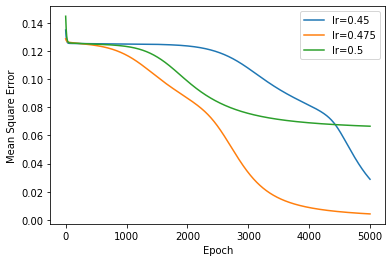

In [31]:
for lr, run in zip(lrs, losses):
    plt.plot(run, label='lr={}'.format(lr))
    plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.show()

In [32]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data

In [33]:
iris_data = pd.read_csv('iris.data', header = None)

In [34]:
data_x = iris_data.values[:, : 4].astype('float')
data_y = iris_data.values[:, 4].reshape(-1, 1)

In [35]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
sss.get_n_splits(data_x, data_y)
#iris_data = iris_data.sample(frac = 1).reset_index(drop = True)

1

In [36]:
train_val_index, test_index = list(sss.split(data_x, data_y))[0]
x_train_val, x_test = data_x[train_val_index], data_x[test_index]
y_train_val, y_test = data_y[train_val_index], data_y[test_index]

In [37]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25, random_state = 42)
sss.get_n_splits(x_train_val, y_train_val)

train_index, val_index = list(sss.split(x_train_val, y_train_val))[0]
x_train, x_val = x_train_val[train_index], x_train_val[val_index]
y_train, y_val = y_train_val[train_index], y_train_val[val_index]


In [38]:
print(len(x_train), len(x_val), len(x_test))
print(len(y_train), len(y_val), len(y_test))

90 30 30
90 30 30


In [39]:
labels2id = {name: i for i, name in enumerate(set(data_y[:, 0]))}

In [40]:
labels2id

{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

In [41]:
onehotencode = lambda i: np.eye(3)[labels2id[i]]
y_train_one_hot = np.asarray([onehotencode(i) for i in y_train[:, 0]])
y_val_one_hot = np.asarray([onehotencode(i) for i in y_val[:, 0]])
y_test_one_hot = np.asarray([onehotencode(i) for i in y_test[:, 0]])

In [42]:
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train_one_hot.shape, y_val_one_hot.shape, y_test_one_hot.shape)

(90, 4) (30, 4) (30, 4)
(90, 3) (30, 3) (30, 3)


In [43]:
layers_iris = [
                FullyConnected(6, 4),
                Sigmoid(),
                FullyConnected(3, 6),
              ]
mymlp_iris = MultiLayerPerceptron(layers_iris, SoftmaxCrossEntropyLoss(), SoftmaxLayer())

In [44]:
print(mymlp_iris)

Fully Connected Layer ID = 8: (In:4, Out:6) 
Sigmoid Layer ID = 8 
Fully Connected Layer ID = 9: (In:6, Out:3) 
Final Layer: Softmax Layer ID = 0 
Loss Layer: Softmax Cross Entropy Loss Layer ID = 0


In [45]:
from sklearn.metrics import precision_recall_fscore_support

def tester(model, x, y_true):
    model.eval_mode()
    out, _ = model.forward(x)
    model.train_mode()
    predictions = np.argmax(out[-1][0], axis=1)
    ground_truth = np.argmax(y_true, axis=1)
    acc = np.mean(predictions == ground_truth)
    precision, recall, fscore, _ = precision_recall_fscore_support(ground_truth, predictions, average='weighted')
    return acc, precision, recall, fscore

In [46]:
tester(mymlp_iris, x_val, y_val_one_hot)

/home/stud/btech/cse/2016/mukuntha.cs16/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.36666666666666664,
 0.20574162679425836,
 0.36666666666666664,
 0.2616310892172961)

In [47]:
tester(mymlp_iris, x_test, y_test_one_hot)

(0.4, 0.24074074074074073, 0.4, 0.2987012987012987)

In [48]:
best_mlp_iris = None
best_f1 = 0.0
losses = []
for epoch in range(500):
    mymlp_iris.train_mode()
    _, loss = mymlp_iris.forward(x_train, y_train_one_hot)
    mymlp_iris.backward()

    train_acc, train_prec, train_rec, train_f1 = tester(mymlp_iris, x_train, y_train_one_hot)
    print("Epoch {} train_acc: {}, train_prec: {}, train_rec: {}, train_f1: {}".format(epoch, train_acc, train_prec, train_rec, train_f1))

    val_acc, val_prec, val_rec, val_f1 = tester(mymlp_iris, x_val, y_val_one_hot)
    print("Epoch {} val_acc: {}, val_prec: {}, val_rec: {}, val_f1: {}".format(epoch, val_acc, val_prec, val_rec, val_f1))

    test_acc, test_prec, test_rec, test_f1 = tester(mymlp_iris, x_test, y_test_one_hot)
    print("Epoch {} test_acc: {}, test_prec: {}, test_rec: {}, test_f1: {}".format(epoch, test_acc, test_prec, test_rec, test_f1))

    if  val_f1 > best_f1:
        best_mlp_iris = deepcopy(mymlp_iris)
        best_f1 = val_f1
        print("Saving as best model...")
    print(mymlp_iris.optimize(1))
    print('Loss',loss)
    losses.append(loss)

Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 0 train_acc: 0.3333333333333333, train_prec: 0.2017543859649123, train_rec: 0.3333333333333333, train_f1: 0.250597800095648
Epoch 0 val_acc: 0.36666666666666664, val_prec: 0.20574162679425836, val_rec: 0.36666666666666664, val_f1: 0.2616310892172961
Epoch 0 test_acc: 0.4, test_prec: 0.24074074074074073, test_rec: 0.4, test_f1: 0.2987012987012987
Saving as best model...
0.6162620893605725
0.5218373986920455
False
Loss 1.1441675791264838
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 1 train_acc: 0.34444444444444444, train_prec: 0.18979266347687404, train_rec: 0.34444444444444444, train_f1: 0.24338624338624343
Epoch 1 val_acc: 0.3333333333333333, val_prec: 0.16666666666666666, val_rec: 0.3333333333333333, va

Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 41 train_acc: 0.6888888888888889, train_prec: 0.839080459770115, train_rec: 0.6888888888888889, train_f1: 0.6022727272727273
Epoch 41 val_acc: 0.7333333333333333, val_prec: 0.8518518518518519, val_rec: 0.7333333333333333, val_f1: 0.6825396825396824
Epoch 41 test_acc: 0.7, test_prec: 0.8421052631578948, test_rec: 0.7, test_f1: 0.6238244514106583
1.6619707659530205
0.7359928281462412
False
Loss 0.41855863184634795
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 42 train_acc: 0.6777777777777778, train_prec: 0.8361581920903954, train_rec: 0.6777777777777778, train_f1: 0.5795578108010149
Epoch 42 val_acc: 0.6666666666666666, val_prec: 0.5, val_rec: 0.6666666666666666, val_f1: 0.5555555555555555
Epoch 42 test_acc: 0.6666666666666666, test_prec: 0.5, test_rec: 0.66666666666

Epoch 97 train_acc: 0.8333333333333334, train_prec: 0.8888888888888888, train_rec: 0.8333333333333334, train_f1: 0.8222222222222222
Epoch 97 val_acc: 0.7333333333333333, val_prec: 0.8518518518518519, val_rec: 0.7333333333333333, val_f1: 0.6825396825396826
Epoch 97 test_acc: 0.8, test_prec: 0.875, test_rec: 0.8, test_f1: 0.7802197802197803
1.8887664735929677
0.6170684364060619
False
Loss 0.3555089277106953
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 98 train_acc: 0.6777777777777778, train_prec: 0.8361581920903954, train_rec: 0.6777777777777778, train_f1: 0.5795578108010149
Epoch 98 val_acc: 0.7333333333333333, val_prec: 0.8518518518518519, val_rec: 0.7333333333333333, val_f1: 0.6825396825396824
Epoch 98 test_acc: 0.6666666666666666, test_prec: 0.5, test_rec: 0.6666666666666666, test_f1: 0.5555555555555555
3.8098919557568527
1.3549314001531636
False
Loss 0.43399002874

Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 154 train_acc: 0.9666666666666667, train_prec: 0.9696969696969698, train_rec: 0.9666666666666667, train_f1: 0.9665831244778613
Epoch 154 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666666666667, val_f1: 0.9665831244778613
Epoch 154 test_acc: 0.9333333333333333, test_prec: 0.9444444444444445, test_rec: 0.9333333333333333, test_f1: 0.9326599326599326
0.7575481251816905
0.22280541688925334
False
Loss 0.3913861777015442
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 155 train_acc: 0.9444444444444444, train_prec: 0.9472502805836138, train_rec: 0.9444444444444444, train_f1: 0.9443052074631023
Epoch 155 val_acc: 1.0, val_prec: 1.0, val_rec: 1.0, val_f1: 1.0
Epoch 155 test_acc: 0.9, t

Epoch 168 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666666666667, val_f1: 0.9665831244778613
Epoch 168 test_acc: 0.8666666666666667, test_prec: 0.9047619047619048, test_rec: 0.8666666666666667, test_f1: 0.861111111111111
0.760138069285808
0.5639177349351733
False
Loss 0.30720311216674395
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 169 train_acc: 0.8333333333333334, train_prec: 0.8888888888888888, train_rec: 0.8333333333333334, train_f1: 0.8222222222222222
Epoch 169 val_acc: 0.7666666666666667, val_prec: 0.8627450980392157, val_rec: 0.7666666666666667, val_f1: 0.7340930674264007
Epoch 169 test_acc: 0.8666666666666667, test_prec: 0.9047619047619048, test_rec: 0.8666666666666667, test_f1: 0.861111111111111
1.6199478411152397
0.4889284633167265
False
Loss 0.33009877792901754
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sig

Epoch 211 test_acc: 0.6666666666666666, test_prec: 0.5, test_rec: 0.6666666666666666, test_f1: 0.5555555555555555
1.7607533539686089
1.4082836759501558
False
Loss 0.49245849372262795
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 212 train_acc: 0.6666666666666666, train_prec: 0.5, train_rec: 0.6666666666666666, train_f1: 0.5555555555555556
Epoch 212 val_acc: 0.6666666666666666, val_prec: 0.5, val_rec: 0.6666666666666666, val_f1: 0.5555555555555555
Epoch 212 test_acc: 0.6666666666666666, test_prec: 0.5, test_rec: 0.6666666666666666, test_f1: 0.5555555555555555
1.1705437605025155
1.3637607729584231
False
Loss 0.589626167693821
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 213 train_acc: 0.9777777777777777, train_prec: 0.9777777777777777, train_rec: 0.97

Epoch 226 train_acc: 0.9222222222222223, train_prec: 0.9295238095238095, train_rec: 0.9222222222222223, train_f1: 0.9216783216783216
Epoch 226 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666666666667, val_f1: 0.9665831244778613
Epoch 226 test_acc: 0.8666666666666667, test_prec: 0.9047619047619048, test_rec: 0.8666666666666667, test_f1: 0.861111111111111
0.6525368760768172
0.6046739280816019
False
Loss 0.2746237069495604
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 227 train_acc: 0.9333333333333333, train_prec: 0.9444444444444444, train_rec: 0.9333333333333333, train_f1: 0.9326599326599326
Epoch 227 val_acc: 0.9, val_prec: 0.9230769230769231, val_rec: 0.9, val_f1: 0.8976982097186702
Epoch 227 test_acc: 0.9, test_prec: 0.9230769230769231, test_rec: 0.9, test_f1: 0.8976982097186702
1.2574808140052525
0.22323321229651377
False
Loss 0.2638116

Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 269 train_acc: 0.7888888888888889, train_prec: 0.8707482993197279, train_rec: 0.7888888888888889, train_f1: 0.7653596789132447
Epoch 269 val_acc: 0.7333333333333333, val_prec: 0.8518518518518519, val_rec: 0.7333333333333333, val_f1: 0.6825396825396826
Epoch 269 test_acc: 0.8, test_prec: 0.875, test_rec: 0.8, test_f1: 0.7802197802197803
2.6107329053895443
0.9317907680491055
False
Loss 0.37842606630025366
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 270 train_acc: 0.8444444444444444, train_prec: 0.8939393939393939, train_rec: 0.8444444444444444, train_f1: 0.8354876615746182
Epoch 270 val_acc: 0.8333333333333334, val_prec: 0.8888888888888888, val_rec: 0.8333333333333334, val_f1: 0.8222222222222222
Epoch 270

Epoch 283 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666666666667, val_f1: 0.9665831244778613
Epoch 283 test_acc: 0.8666666666666667, test_prec: 0.9047619047619048, test_rec: 0.8666666666666667, test_f1: 0.861111111111111
2.3697769098342385
0.6852499458435481
False
Loss 0.20968778844381078
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 284 train_acc: 0.7777777777777778, train_prec: 0.8666666666666667, train_rec: 0.7777777777777778, train_f1: 0.75
Epoch 284 val_acc: 0.7, val_prec: 0.8421052631578948, val_rec: 0.7, val_f1: 0.6238244514106583
Epoch 284 test_acc: 0.7666666666666667, test_prec: 0.8627450980392157, test_rec: 0.7666666666666667, test_f1: 0.7340930674264007
3.174127588059199
1.1857083442041505
False
Loss 0.4434832945922534
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Con

Epoch 326 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666666666667, val_f1: 0.9665831244778613
Epoch 326 test_acc: 0.8666666666666667, test_prec: 0.9047619047619048, test_rec: 0.8666666666666667, test_f1: 0.861111111111111
2.008583552493559
0.670281810399824
False
Loss 0.210645767197437
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 327 train_acc: 0.8666666666666667, train_prec: 0.9047619047619048, train_rec: 0.8666666666666667, train_f1: 0.8611111111111112
Epoch 327 val_acc: 0.8333333333333334, val_prec: 0.8888888888888888, val_rec: 0.8333333333333334, val_f1: 0.8222222222222222
Epoch 327 test_acc: 0.8666666666666667, test_prec: 0.9047619047619048, test_rec: 0.8666666666666667, test_f1: 0.861111111111111
2.234919990858627
0.6080805648026263
False
Loss 0.2544806532512196
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid 

Epoch 340 test_acc: 0.8666666666666667, test_prec: 0.9047619047619048, test_rec: 0.8666666666666667, test_f1: 0.861111111111111
2.4108615384004555
0.7223371528386544
False
Loss 0.2111958045191801
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 341 train_acc: 0.8666666666666667, train_prec: 0.9047619047619048, train_rec: 0.8666666666666667, train_f1: 0.8611111111111112
Epoch 341 val_acc: 0.8333333333333334, val_prec: 0.8888888888888888, val_rec: 0.8333333333333334, val_f1: 0.8222222222222222
Epoch 341 test_acc: 0.8666666666666667, test_prec: 0.9047619047619048, test_rec: 0.8666666666666667, test_f1: 0.861111111111111
2.2718254771554003
0.6018922862670458
False
Loss 0.2511924908815616
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 342 train_acc: 0.9333333

Epoch 384 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666666666667, val_f1: 0.9665831244778613
Epoch 384 test_acc: 1.0, test_prec: 1.0, test_rec: 1.0, test_f1: 1.0
0.1555102519069232
0.1594120796536026
False
Loss 0.10265373550253551
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 385 train_acc: 0.9777777777777777, train_prec: 0.9791666666666666, train_rec: 0.9777777777777777, train_f1: 0.9777530589543938
Epoch 385 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666666666667, val_f1: 0.9665831244778613
Epoch 385 test_acc: 0.9666666666666667, test_prec: 0.9696969696969696, test_rec: 0.9666666666666667, test_f1: 0.9665831244778613
0.2245491065195796
0.09187625534000995
False
Loss 0.1003145763593973
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer 

Epoch 398 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666666666667, val_f1: 0.9665831244778613
Epoch 398 test_acc: 1.0, test_prec: 1.0, test_rec: 1.0, test_f1: 1.0
0.4753706581684662
0.11916740229716427
False
Loss 0.09252868087123159
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 399 train_acc: 0.9777777777777777, train_prec: 0.9791666666666666, train_rec: 0.9777777777777777, train_f1: 0.9777530589543938
Epoch 399 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666666666667, val_f1: 0.9665831244778613
Epoch 399 test_acc: 0.9666666666666667, test_prec: 0.9696969696969696, test_rec: 0.9666666666666667, test_f1: 0.9665831244778613
0.5727199421755718
0.10771576899538357
False
Loss 0.09500424147871846
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Laye

Epoch 442 test_acc: 0.9, test_prec: 0.9230769230769231, test_rec: 0.9, test_f1: 0.8976982097186702
1.7712217631378284
0.3972322773208776
False
Loss 0.15080745653356928
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 443 train_acc: 0.9333333333333333, train_prec: 0.9381598793363499, train_rec: 0.9333333333333333, train_f1: 0.9330357142857143
Epoch 443 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666666666667, val_f1: 0.9665831244778613
Epoch 443 test_acc: 0.9, test_prec: 0.9230769230769231, test_rec: 0.9, test_f1: 0.8976982097186702
2.526310544263723
0.4468558233519709
False
Loss 0.14562892637551522
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 444 train_acc: 0.8777777777777778, train_prec: 0.910569105691057, train_rec: 0.87

Epoch 456 test_acc: 0.9666666666666667, test_prec: 0.9696969696969696, test_rec: 0.9666666666666667, test_f1: 0.9665831244778613
0.15444250436077744
0.10557366363108028
False
Loss 0.08833363653648571
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 457 train_acc: 0.9777777777777777, train_prec: 0.9791666666666666, train_rec: 0.9777777777777777, train_f1: 0.9777530589543938
Epoch 457 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666666666667, val_f1: 0.9665831244778613
Epoch 457 test_acc: 0.9666666666666667, test_prec: 0.9696969696969696, test_rec: 0.9666666666666667, test_f1: 0.9665831244778613
0.21300305476625858
0.05433523706436183
False
Loss 0.08748029355661426
Fully Connected Layer ID = 8: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 8 (90, 6), (90, 6)
Fully Connected Layer ID = 9: (In:6, Out:3) (90, 6), (90, 3)
Epoch 458 train_acc: 0

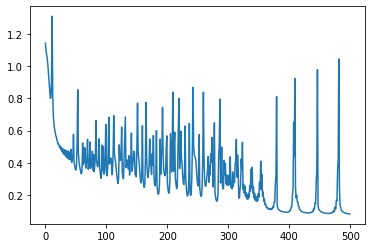

In [49]:
plt.plot(losses)
plt.show()

In [50]:
test_acc, test_prec, test_rec, test_f1 = tester(best_mlp_iris, x_test, y_test_one_hot)
print("TEST: test_acc: {}, test_prec: {}, test_rec: {}, test_f1: {}".format(test_acc, test_prec, test_rec, test_f1))

TEST: test_acc: 0.8666666666666667, test_prec: 0.9047619047619048, test_rec: 0.8666666666666667, test_f1: 0.861111111111111


In [51]:
all_losses = []
lrs = [0.3, 1, 1.3]
for lr in lrs:
    layers_iris = [
                FullyConnected(6, 4),
                Sigmoid(),
                FullyConnected(3, 6),
              ]
    mymlp_iris = MultiLayerPerceptron(layers_iris, SoftmaxCrossEntropyLoss(), SoftmaxLayer())
    best_mlp_iris = None
    best_f1 = 0.0
    losses = []
    for epoch in range(500):
        mymlp_iris.train_mode()
        _, loss = mymlp_iris.forward(x_train, y_train_one_hot)
        mymlp_iris.backward()

        train_acc, train_prec, train_rec, train_f1 = tester(mymlp_iris, x_train, y_train_one_hot)
        print("Epoch {} train_acc: {}, train_prec: {}, train_rec: {}, train_f1: {}".format(epoch, train_acc, train_prec, train_rec, train_f1))

        val_acc, val_prec, val_rec, val_f1 = tester(mymlp_iris, x_val, y_val_one_hot)
        print("Epoch {} val_acc: {}, val_prec: {}, val_rec: {}, val_f1: {}".format(epoch, val_acc, val_prec, val_rec, val_f1))

        test_acc, test_prec, test_rec, test_f1 = tester(mymlp_iris, x_test, y_test_one_hot)
        print("Epoch {} test_acc: {}, test_prec: {}, test_rec: {}, test_f1: {}".format(epoch, test_acc, test_prec, test_rec, test_f1))

        if  val_f1 > best_f1:
            best_mlp_iris = deepcopy(mymlp_iris)
            best_f1 = val_f1
            print("Saving as best model...")
        print(mymlp_iris.optimize(lr))
        print('Loss',loss)
        losses.append(loss)
    all_losses.append(losses)

Fully Connected Layer ID = 10: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 9 (90, 6), (90, 6)
Fully Connected Layer ID = 11: (In:6, Out:3) (90, 6), (90, 3)
Epoch 0 train_acc: 0.3333333333333333, train_prec: 0.1111111111111111, train_rec: 0.3333333333333333, train_f1: 0.16666666666666666
Epoch 0 val_acc: 0.3333333333333333, val_prec: 0.1111111111111111, val_rec: 0.3333333333333333, val_f1: 0.16666666666666666
Epoch 0 test_acc: 0.3333333333333333, test_prec: 0.1111111111111111, test_rec: 0.3333333333333333, test_f1: 0.16666666666666666
Saving as best model...
0.8560050820703472
1.8769713276394602
False
Loss 1.2162780095322325
Fully Connected Layer ID = 10: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 9 (90, 6), (90, 6)
Fully Connected Layer ID = 11: (In:6, Out:3) (90, 6), (90, 3)
Epoch 1 train_acc: 0.3333333333333333, train_prec: 0.1111111111111111, train_rec: 0.3333333333333333, train_f1: 0.16666666666666666
Epoch 1 val_acc: 0.3, val_prec: 0.10344827586206896, val_rec: 0.3, v

Fully Connected Layer ID = 10: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 9 (90, 6), (90, 6)
Fully Connected Layer ID = 11: (In:6, Out:3) (90, 6), (90, 3)
Epoch 55 train_acc: 0.8333333333333334, train_prec: 0.8888888888888888, train_rec: 0.8333333333333334, train_f1: 0.8222222222222222
Epoch 55 val_acc: 0.8333333333333334, val_prec: 0.8888888888888888, val_rec: 0.8333333333333334, val_f1: 0.8222222222222222
Epoch 55 test_acc: 0.8666666666666667, test_prec: 0.9047619047619048, test_rec: 0.8666666666666667, test_f1: 0.861111111111111
0.4060347651404348
0.42101539347892164
False
Loss 0.6280263569449052
Fully Connected Layer ID = 10: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 9 (90, 6), (90, 6)
Fully Connected Layer ID = 11: (In:6, Out:3) (90, 6), (90, 3)
Epoch 56 train_acc: 0.8555555555555555, train_prec: 0.8992248062015504, train_rec: 0.8555555555555555, train_f1: 0.848440687846109
Epoch 56 val_acc: 0.8333333333333334, val_prec: 0.8888888888888888, val_rec: 0.83333333333333

Epoch 113 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666666666667, val_f1: 0.9665831244778613
Epoch 113 test_acc: 0.9666666666666667, test_prec: 0.9696969696969696, test_rec: 0.9666666666666667, test_f1: 0.9665831244778613
0.21348420066158313
0.2302638580496107
False
Loss 0.4145264914158415
Fully Connected Layer ID = 10: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 9 (90, 6), (90, 6)
Fully Connected Layer ID = 11: (In:6, Out:3) (90, 6), (90, 3)
Epoch 114 train_acc: 0.9666666666666667, train_prec: 0.9696969696969698, train_rec: 0.9666666666666667, train_f1: 0.9665831244778613
Epoch 114 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666666666667, val_f1: 0.9665831244778613
Epoch 114 test_acc: 0.9666666666666667, test_prec: 0.9696969696969696, test_rec: 0.9666666666666667, test_f1: 0.9665831244778613
0.21261676084279285
0.22977271054036869
False
Loss 0.4122333844976613
Fully Connected Layer ID = 10: (In:4, Out:6) (90, 4), (90,

Fully Connected Layer ID = 10: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 9 (90, 6), (90, 6)
Fully Connected Layer ID = 11: (In:6, Out:3) (90, 6), (90, 3)
Epoch 170 train_acc: 0.9666666666666667, train_prec: 0.9696969696969698, train_rec: 0.9666666666666667, train_f1: 0.9665831244778613
Epoch 170 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666666666667, val_f1: 0.9665831244778613
Epoch 170 test_acc: 1.0, test_prec: 1.0, test_rec: 1.0, test_f1: 1.0
0.1761227404465465
0.20095633821508127
False
Loss 0.29890019286558817
Fully Connected Layer ID = 10: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 9 (90, 6), (90, 6)
Fully Connected Layer ID = 11: (In:6, Out:3) (90, 6), (90, 3)
Epoch 171 train_acc: 0.9666666666666667, train_prec: 0.9696969696969698, train_rec: 0.9666666666666667, train_f1: 0.9665831244778613
Epoch 171 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666666666667, val_f1: 0.9665831244778613
Epoch 171 test_acc: 1

Epoch 227 test_acc: 0.8333333333333334, test_prec: 0.8888888888888888, test_rec: 0.8333333333333334, test_f1: 0.8222222222222222
2.666942462548547
1.1206021618483484
False
Loss 0.2928246049798551
Fully Connected Layer ID = 10: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 9 (90, 6), (90, 6)
Fully Connected Layer ID = 11: (In:6, Out:3) (90, 6), (90, 3)
Epoch 228 train_acc: 0.8444444444444444, train_prec: 0.8939393939393939, train_rec: 0.8444444444444444, train_f1: 0.8354876615746182
Epoch 228 val_acc: 0.7666666666666667, val_prec: 0.8627450980392157, val_rec: 0.7666666666666667, val_f1: 0.7340930674264007
Epoch 228 test_acc: 0.8666666666666667, test_prec: 0.9047619047619048, test_rec: 0.8666666666666667, test_f1: 0.861111111111111
2.616855447403458
1.1294940208008857
False
Loss 0.32984364502994157
Fully Connected Layer ID = 10: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 9 (90, 6), (90, 6)
Fully Connected Layer ID = 11: (In:6, Out:3) (90, 6), (90, 3)
Epoch 229 train_acc: 0.911

Fully Connected Layer ID = 10: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 9 (90, 6), (90, 6)
Fully Connected Layer ID = 11: (In:6, Out:3) (90, 6), (90, 3)
Epoch 286 train_acc: 0.8666666666666667, train_prec: 0.9047619047619048, train_rec: 0.8666666666666667, train_f1: 0.8611111111111112
Epoch 286 val_acc: 0.8666666666666667, val_prec: 0.9047619047619048, val_rec: 0.8666666666666667, val_f1: 0.861111111111111
Epoch 286 test_acc: 0.8666666666666667, test_prec: 0.9047619047619048, test_rec: 0.8666666666666667, test_f1: 0.861111111111111
2.45616029162165
0.9610699771253305
False
Loss 0.2638732226594546
Fully Connected Layer ID = 10: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 9 (90, 6), (90, 6)
Fully Connected Layer ID = 11: (In:6, Out:3) (90, 6), (90, 3)
Epoch 287 train_acc: 0.9222222222222223, train_prec: 0.9369369369369369, train_rec: 0.9222222222222223, train_f1: 0.9211489721205295
Epoch 287 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.966666666666

Epoch 342 val_acc: 0.9333333333333333, val_prec: 0.9444444444444445, val_rec: 0.9333333333333333, val_f1: 0.9326599326599326
Epoch 342 test_acc: 0.9, test_prec: 0.9230769230769231, test_rec: 0.9, test_f1: 0.8976982097186702
1.8804532868913817
0.667845883231108
False
Loss 0.19524401107907255
Fully Connected Layer ID = 10: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 9 (90, 6), (90, 6)
Fully Connected Layer ID = 11: (In:6, Out:3) (90, 6), (90, 3)
Epoch 343 train_acc: 0.9333333333333333, train_prec: 0.9381598793363499, train_rec: 0.9333333333333333, train_f1: 0.9330357142857143
Epoch 343 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666666666667, val_f1: 0.9665831244778613
Epoch 343 test_acc: 0.9, test_prec: 0.9230769230769231, test_rec: 0.9, test_f1: 0.8976982097186702
1.882995638811757
0.673566534110261
False
Loss 0.18294678663380654
Fully Connected Layer ID = 10: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 9 (90, 6), (90, 6)
Fully Connected Layer 

Fully Connected Layer ID = 10: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 9 (90, 6), (90, 6)
Fully Connected Layer ID = 11: (In:6, Out:3) (90, 6), (90, 3)
Epoch 401 train_acc: 0.9555555555555556, train_prec: 0.9568452380952381, train_rec: 0.9555555555555556, train_f1: 0.9555061179087875
Epoch 401 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666666666667, val_f1: 0.9665831244778613
Epoch 401 test_acc: 0.9666666666666667, test_prec: 0.9696969696969696, test_rec: 0.9666666666666667, test_f1: 0.9665831244778613
1.3025250851961823
0.4313917464074749
False
Loss 0.14407170647254752
Fully Connected Layer ID = 10: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 9 (90, 6), (90, 6)
Fully Connected Layer ID = 11: (In:6, Out:3) (90, 6), (90, 3)
Epoch 402 train_acc: 0.9555555555555556, train_prec: 0.9607843137254902, train_rec: 0.9555555555555556, train_f1: 0.9553571428571429
Epoch 402 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666

Epoch 459 train_acc: 0.9555555555555556, train_prec: 0.9568452380952381, train_rec: 0.9555555555555556, train_f1: 0.9555061179087875
Epoch 459 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666666666667, val_f1: 0.9665831244778613
Epoch 459 test_acc: 1.0, test_prec: 1.0, test_rec: 1.0, test_f1: 1.0
1.0020049366987178
0.31202395415109796
False
Loss 0.12316396585264143
Fully Connected Layer ID = 10: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 9 (90, 6), (90, 6)
Fully Connected Layer ID = 11: (In:6, Out:3) (90, 6), (90, 3)
Epoch 460 train_acc: 0.9555555555555556, train_prec: 0.9607843137254902, train_rec: 0.9555555555555556, train_f1: 0.9553571428571429
Epoch 460 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666666666667, val_f1: 0.9665831244778613
Epoch 460 test_acc: 0.9666666666666667, test_prec: 0.9696969696969696, test_rec: 0.9666666666666667, test_f1: 0.9665831244778613
0.9902735413015328
0.31032200183536945
False
Loss 0.12

Epoch 15 val_acc: 0.3333333333333333, val_prec: 0.15873015873015872, val_rec: 0.3333333333333333, val_f1: 0.2150537634408602
Epoch 15 test_acc: 0.36666666666666664, test_prec: 0.4920634920634921, test_rec: 0.36666666666666664, test_f1: 0.2756598240469208
2.065629811334262
1.830050515142942
False
Loss 1.044156976513285
Fully Connected Layer ID = 12: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 10 (90, 6), (90, 6)
Fully Connected Layer ID = 13: (In:6, Out:3) (90, 6), (90, 3)
Epoch 16 train_acc: 0.6444444444444445, train_prec: 0.4705667942409332, train_rec: 0.6444444444444445, train_f1: 0.5307300300853441
Epoch 16 val_acc: 0.6666666666666666, val_prec: 0.5, val_rec: 0.6666666666666666, val_f1: 0.5555555555555555
Epoch 16 test_acc: 0.5666666666666667, test_prec: 0.4782608695652174, test_rec: 0.5666666666666667, test_f1: 0.47653000594177064
2.220235536831057
1.9890876175299268
False
Loss 0.9329510849853268
Fully Connected Layer ID = 12: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID =

Fully Connected Layer ID = 12: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 10 (90, 6), (90, 6)
Fully Connected Layer ID = 13: (In:6, Out:3) (90, 6), (90, 3)
Epoch 73 train_acc: 0.9444444444444444, train_prec: 0.9523809523809523, train_rec: 0.9444444444444444, train_f1: 0.944055944055944
Epoch 73 val_acc: 0.9333333333333333, val_prec: 0.9444444444444445, val_rec: 0.9333333333333333, val_f1: 0.9326599326599326
Epoch 73 test_acc: 0.9, test_prec: 0.9230769230769231, test_rec: 0.9, test_f1: 0.8976982097186702
0.11692808383547866
0.14499718916189097
False
Loss 0.4543595919251129
Fully Connected Layer ID = 12: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 10 (90, 6), (90, 6)
Fully Connected Layer ID = 13: (In:6, Out:3) (90, 6), (90, 3)
Epoch 74 train_acc: 0.9444444444444444, train_prec: 0.9523809523809523, train_rec: 0.9444444444444444, train_f1: 0.944055944055944
Epoch 74 val_acc: 0.9333333333333333, val_prec: 0.9444444444444445, val_rec: 0.9333333333333333, val_f1: 0.9326599326599

Fully Connected Layer ID = 12: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 10 (90, 6), (90, 6)
Fully Connected Layer ID = 13: (In:6, Out:3) (90, 6), (90, 3)
Epoch 131 train_acc: 0.9333333333333333, train_prec: 0.9331349206349207, train_rec: 0.9333333333333333, train_f1: 0.9325423309850451
Epoch 131 val_acc: 1.0, val_prec: 1.0, val_rec: 1.0, val_f1: 1.0
Epoch 131 test_acc: 0.9333333333333333, test_prec: 0.9444444444444445, test_rec: 0.9333333333333333, test_f1: 0.9326599326599326
0.8780205466007731
0.483387079834971
False
Loss 0.4012616987161524
Fully Connected Layer ID = 12: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 10 (90, 6), (90, 6)
Fully Connected Layer ID = 13: (In:6, Out:3) (90, 6), (90, 3)
Epoch 132 train_acc: 0.6777777777777778, train_prec: 0.8361581920903954, train_rec: 0.6777777777777778, train_f1: 0.5795578108010149
Epoch 132 val_acc: 0.6666666666666666, val_prec: 0.5, val_rec: 0.6666666666666666, val_f1: 0.5555555555555555
Epoch 132 test_acc: 0.666666666666666

Epoch 188 val_acc: 0.8333333333333334, val_prec: 0.8498168498168498, val_rec: 0.8333333333333334, val_f1: 0.8294970161977834
Epoch 188 test_acc: 0.8666666666666667, test_prec: 0.9047619047619048, test_rec: 0.8666666666666667, test_f1: 0.861111111111111
0.17816073061886958
0.06963882122449218
False
Loss 0.4333443953712535
Fully Connected Layer ID = 12: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 10 (90, 6), (90, 6)
Fully Connected Layer ID = 13: (In:6, Out:3) (90, 6), (90, 3)
Epoch 189 train_acc: 0.9444444444444444, train_prec: 0.9523809523809523, train_rec: 0.9444444444444444, train_f1: 0.944055944055944
Epoch 189 val_acc: 0.8333333333333334, val_prec: 0.8498168498168498, val_rec: 0.8333333333333334, val_f1: 0.8294970161977834
Epoch 189 test_acc: 0.8666666666666667, test_prec: 0.9047619047619048, test_rec: 0.8666666666666667, test_f1: 0.861111111111111
0.21088432930229245
0.0750303057307934
False
Loss 0.42861178502074854
Fully Connected Layer ID = 12: (In:4, Out:6) (90, 4), (90, 

Fully Connected Layer ID = 12: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 10 (90, 6), (90, 6)
Fully Connected Layer ID = 13: (In:6, Out:3) (90, 6), (90, 3)
Epoch 247 train_acc: 0.7666666666666667, train_prec: 0.8627450980392157, train_rec: 0.7666666666666667, train_f1: 0.7340930674264008
Epoch 247 val_acc: 0.8, val_prec: 0.875, val_rec: 0.8, val_f1: 0.7802197802197803
Epoch 247 test_acc: 0.8, test_prec: 0.875, test_rec: 0.8, test_f1: 0.7802197802197803
0.9145548246957247
0.9270573486604026
False
Loss 0.3498508911305565
Fully Connected Layer ID = 12: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 10 (90, 6), (90, 6)
Fully Connected Layer ID = 13: (In:6, Out:3) (90, 6), (90, 3)
Epoch 248 train_acc: 0.9444444444444444, train_prec: 0.9523809523809523, train_rec: 0.9444444444444444, train_f1: 0.944055944055944
Epoch 248 val_acc: 0.9333333333333333, val_prec: 0.9444444444444445, val_rec: 0.9333333333333333, val_f1: 0.9326599326599326
Epoch 248 test_acc: 0.9, test_prec: 0.9230769230

Epoch 304 test_acc: 0.8333333333333334, test_prec: 0.8888888888888888, test_rec: 0.8333333333333334, test_f1: 0.8222222222222222
1.079748533343619
1.0315284412441272
False
Loss 0.38108033381046424
Fully Connected Layer ID = 12: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 10 (90, 6), (90, 6)
Fully Connected Layer ID = 13: (In:6, Out:3) (90, 6), (90, 3)
Epoch 305 train_acc: 0.7, train_prec: 0.8421052631578947, train_rec: 0.7, train_f1: 0.6238244514106583
Epoch 305 val_acc: 0.6666666666666666, val_prec: 0.5, val_rec: 0.6666666666666666, val_f1: 0.5555555555555555
Epoch 305 test_acc: 0.7333333333333333, test_prec: 0.8518518518518519, test_rec: 0.7333333333333333, test_f1: 0.6825396825396826
1.0445035366172364
1.03890357008952
False
Loss 0.46363710588641416
Fully Connected Layer ID = 12: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 10 (90, 6), (90, 6)
Fully Connected Layer ID = 13: (In:6, Out:3) (90, 6), (90, 3)
Epoch 306 train_acc: 0.9444444444444444, train_prec: 0.9472502805836

Fully Connected Layer ID = 12: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 10 (90, 6), (90, 6)
Fully Connected Layer ID = 13: (In:6, Out:3) (90, 6), (90, 3)
Epoch 363 train_acc: 0.8333333333333334, train_prec: 0.8888888888888888, train_rec: 0.8333333333333334, train_f1: 0.8222222222222222
Epoch 363 val_acc: 0.8666666666666667, val_prec: 0.9047619047619048, val_rec: 0.8666666666666667, val_f1: 0.861111111111111
Epoch 363 test_acc: 0.8, test_prec: 0.875, test_rec: 0.8, test_f1: 0.7802197802197803
3.22206436201197
1.370589573271685
False
Loss 0.33290238910820147
Fully Connected Layer ID = 12: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 10 (90, 6), (90, 6)
Fully Connected Layer ID = 13: (In:6, Out:3) (90, 6), (90, 3)
Epoch 364 train_acc: 0.6888888888888889, train_prec: 0.839080459770115, train_rec: 0.6888888888888889, train_f1: 0.6022727272727273
Epoch 364 val_acc: 0.6666666666666666, val_prec: 0.5, val_rec: 0.6666666666666666, val_f1: 0.5555555555555555
Epoch 364 test_acc: 0.6

Epoch 420 val_acc: 0.6666666666666666, val_prec: 0.5, val_rec: 0.6666666666666666, val_f1: 0.5555555555555555
Epoch 420 test_acc: 0.7333333333333333, test_prec: 0.8518518518518519, test_rec: 0.7333333333333333, test_f1: 0.6825396825396826
2.6270606454657845
1.831870197039052
False
Loss 0.6307909965623807
Fully Connected Layer ID = 12: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 10 (90, 6), (90, 6)
Fully Connected Layer ID = 13: (In:6, Out:3) (90, 6), (90, 3)
Epoch 421 train_acc: 0.9, train_prec: 0.9086917562724014, train_rec: 0.9, train_f1: 0.8989989569224541
Epoch 421 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666666666667, val_f1: 0.9665831244778613
Epoch 421 test_acc: 0.8666666666666667, test_prec: 0.9047619047619048, test_rec: 0.8666666666666667, test_f1: 0.861111111111111
2.401020495437485
1.1397313877089874
False
Loss 0.3277158035373013
Fully Connected Layer ID = 12: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 10 (90, 6), (90, 6)
Fully C

Fully Connected Layer ID = 12: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 10 (90, 6), (90, 6)
Fully Connected Layer ID = 13: (In:6, Out:3) (90, 6), (90, 3)
Epoch 479 train_acc: 0.7777777777777778, train_prec: 0.8666666666666667, train_rec: 0.7777777777777778, train_f1: 0.75
Epoch 479 val_acc: 0.7, val_prec: 0.8421052631578948, val_rec: 0.7, val_f1: 0.6238244514106583
Epoch 479 test_acc: 0.7666666666666667, test_prec: 0.8627450980392157, test_rec: 0.7666666666666667, test_f1: 0.7340930674264007
3.1470594670947385
1.5783156019626423
False
Loss 0.5317146879555608
Fully Connected Layer ID = 12: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 10 (90, 6), (90, 6)
Fully Connected Layer ID = 13: (In:6, Out:3) (90, 6), (90, 3)
Epoch 480 train_acc: 0.8111111111111111, train_prec: 0.8794326241134751, train_rec: 0.8111111111111111, train_f1: 0.7946239806704923
Epoch 480 val_acc: 0.8333333333333334, val_prec: 0.8888888888888888, val_rec: 0.8333333333333334, val_f1: 0.8222222222222222
Epoch

Fully Connected Layer ID = 14: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 11 (90, 6), (90, 6)
Fully Connected Layer ID = 15: (In:6, Out:3) (90, 6), (90, 3)
Epoch 36 train_acc: 0.6666666666666666, train_prec: 0.5, train_rec: 0.6666666666666666, train_f1: 0.5555555555555556
Epoch 36 val_acc: 0.6666666666666666, val_prec: 0.5, val_rec: 0.6666666666666666, val_f1: 0.5555555555555555
Epoch 36 test_acc: 0.6666666666666666, test_prec: 0.5, test_rec: 0.6666666666666666, test_f1: 0.5555555555555555
0.1954721108811302
0.8742565462616773
False
Loss 0.5095890618159395
Fully Connected Layer ID = 14: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 11 (90, 6), (90, 6)
Fully Connected Layer ID = 15: (In:6, Out:3) (90, 6), (90, 3)
Epoch 37 train_acc: 0.7, train_prec: 0.8421052631578947, train_rec: 0.7, train_f1: 0.6238244514106583
Epoch 37 val_acc: 0.6666666666666666, val_prec: 0.5, val_rec: 0.6666666666666666, val_f1: 0.5555555555555555
Epoch 37 test_acc: 0.7, test_prec: 0.8421052631578948, t

Epoch 93 test_acc: 0.6666666666666666, test_prec: 0.5, test_rec: 0.6666666666666666, test_f1: 0.5555555555555555
0.9526255753002539
0.7371798234489619
False
Loss 0.45770731001039955
Fully Connected Layer ID = 14: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 11 (90, 6), (90, 6)
Fully Connected Layer ID = 15: (In:6, Out:3) (90, 6), (90, 3)
Epoch 94 train_acc: 0.6777777777777778, train_prec: 0.8361581920903954, train_rec: 0.6777777777777778, train_f1: 0.5795578108010149
Epoch 94 val_acc: 0.6666666666666666, val_prec: 0.5, val_rec: 0.6666666666666666, val_f1: 0.5555555555555555
Epoch 94 test_acc: 0.6666666666666666, test_prec: 0.5, test_rec: 0.6666666666666666, test_f1: 0.5555555555555555
0.5387692899202214
0.6947664090802271
False
Loss 0.382812814324548
Fully Connected Layer ID = 14: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 11 (90, 6), (90, 6)
Fully Connected Layer ID = 15: (In:6, Out:3) (90, 6), (90, 3)
Epoch 95 train_acc: 0.9666666666666667, train_prec: 0.9696969696969698,

Epoch 151 train_acc: 0.6666666666666666, train_prec: 0.5, train_rec: 0.6666666666666666, train_f1: 0.5555555555555556
Epoch 151 val_acc: 0.6666666666666666, val_prec: 0.5, val_rec: 0.6666666666666666, val_f1: 0.5555555555555555
Epoch 151 test_acc: 0.6666666666666666, test_prec: 0.5, test_rec: 0.6666666666666666, test_f1: 0.5555555555555555
1.5471699797778873
0.916573690112147
False
Loss 0.4490166591288637
Fully Connected Layer ID = 14: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 11 (90, 6), (90, 6)
Fully Connected Layer ID = 15: (In:6, Out:3) (90, 6), (90, 3)
Epoch 152 train_acc: 0.6666666666666666, train_prec: 0.5, train_rec: 0.6666666666666666, train_f1: 0.5555555555555556
Epoch 152 val_acc: 0.6666666666666666, val_prec: 0.5, val_rec: 0.6666666666666666, val_f1: 0.5555555555555555
Epoch 152 test_acc: 0.6666666666666666, test_prec: 0.5, test_rec: 0.6666666666666666, test_f1: 0.5555555555555555
0.7536392715284186
0.8477293083299442
False
Loss 0.5603582695105414
Fully Connected La

Sigmoid Layer ID = 11 (90, 6), (90, 6)
Fully Connected Layer ID = 15: (In:6, Out:3) (90, 6), (90, 3)
Epoch 209 train_acc: 0.6666666666666666, train_prec: 0.5, train_rec: 0.6666666666666666, train_f1: 0.5555555555555556
Epoch 209 val_acc: 0.6666666666666666, val_prec: 0.5, val_rec: 0.6666666666666666, val_f1: 0.5555555555555555
Epoch 209 test_acc: 0.6666666666666666, test_prec: 0.5, test_rec: 0.6666666666666666, test_f1: 0.5555555555555555
0.7424565564401792
0.7800593562801942
False
Loss 0.5379072287838389
Fully Connected Layer ID = 14: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 11 (90, 6), (90, 6)
Fully Connected Layer ID = 15: (In:6, Out:3) (90, 6), (90, 3)
Epoch 210 train_acc: 0.8777777777777778, train_prec: 0.910569105691057, train_rec: 0.8777777777777778, train_f1: 0.8735268755389479
Epoch 210 val_acc: 0.9, val_prec: 0.9230769230769231, val_rec: 0.9, val_f1: 0.8976982097186702
Epoch 210 test_acc: 0.8333333333333334, test_prec: 0.8888888888888888, test_rec: 0.8333333333333334

Fully Connected Layer ID = 14: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 11 (90, 6), (90, 6)
Fully Connected Layer ID = 15: (In:6, Out:3) (90, 6), (90, 3)
Epoch 267 train_acc: 0.8, train_prec: 0.875, train_rec: 0.8, train_f1: 0.7802197802197803
Epoch 267 val_acc: 0.8333333333333334, val_prec: 0.8888888888888888, val_rec: 0.8333333333333334, val_f1: 0.8222222222222222
Epoch 267 test_acc: 0.8333333333333334, test_prec: 0.8888888888888888, test_rec: 0.8333333333333334, test_f1: 0.8222222222222222
0.6266784362182661
0.14961124005995813
False
Loss 0.4235674655389047
Fully Connected Layer ID = 14: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 11 (90, 6), (90, 6)
Fully Connected Layer ID = 15: (In:6, Out:3) (90, 6), (90, 3)
Epoch 268 train_acc: 0.8444444444444444, train_prec: 0.8939393939393939, train_rec: 0.8444444444444444, train_f1: 0.8354876615746182
Epoch 268 val_acc: 0.8666666666666667, val_prec: 0.9047619047619048, val_rec: 0.8666666666666667, val_f1: 0.861111111111111
Epoc

Fully Connected Layer ID = 14: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 11 (90, 6), (90, 6)
Fully Connected Layer ID = 15: (In:6, Out:3) (90, 6), (90, 3)
Epoch 325 train_acc: 0.8888888888888888, train_prec: 0.9166666666666666, train_rec: 0.8888888888888888, train_f1: 0.8857142857142857
Epoch 325 val_acc: 0.9, val_prec: 0.9230769230769231, val_rec: 0.9, val_f1: 0.8976982097186702
Epoch 325 test_acc: 0.8666666666666667, test_prec: 0.9047619047619048, test_rec: 0.8666666666666667, test_f1: 0.861111111111111
1.3068111813256982
0.7015353180643766
False
Loss 0.2560363378995643
Fully Connected Layer ID = 14: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 11 (90, 6), (90, 6)
Fully Connected Layer ID = 15: (In:6, Out:3) (90, 6), (90, 3)
Epoch 326 train_acc: 0.6888888888888889, train_prec: 0.839080459770115, train_rec: 0.6888888888888889, train_f1: 0.6022727272727273
Epoch 326 val_acc: 0.7, val_prec: 0.8421052631578948, val_rec: 0.7, val_f1: 0.6238244514106583
Epoch 326 test_acc: 0.7

Epoch 382 test_acc: 0.8333333333333334, test_prec: 0.8888888888888888, test_rec: 0.8333333333333334, test_f1: 0.8222222222222222
2.0910016199097465
0.8480365225112468
False
Loss 0.27146017364196917
Fully Connected Layer ID = 14: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 11 (90, 6), (90, 6)
Fully Connected Layer ID = 15: (In:6, Out:3) (90, 6), (90, 3)
Epoch 383 train_acc: 0.7, train_prec: 0.8421052631578947, train_rec: 0.7, train_f1: 0.6238244514106583
Epoch 383 val_acc: 0.7, val_prec: 0.8421052631578948, val_rec: 0.7, val_f1: 0.6238244514106583
Epoch 383 test_acc: 0.7333333333333333, test_prec: 0.8518518518518519, test_rec: 0.7333333333333333, test_f1: 0.6825396825396826
2.332092126490024
1.245071779298326
False
Loss 0.5031464387014537
Fully Connected Layer ID = 14: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 11 (90, 6), (90, 6)
Fully Connected Layer ID = 15: (In:6, Out:3) (90, 6), (90, 3)
Epoch 384 train_acc: 0.6888888888888889, train_prec: 0.839080459770115, train_rec: 

Epoch 439 test_acc: 0.6666666666666666, test_prec: 0.5, test_rec: 0.6666666666666666, test_f1: 0.5555555555555555
2.217668016168189
1.321229408448914
False
Loss 0.6221344736238588
Fully Connected Layer ID = 14: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 11 (90, 6), (90, 6)
Fully Connected Layer ID = 15: (In:6, Out:3) (90, 6), (90, 3)
Epoch 440 train_acc: 0.7888888888888889, train_prec: 0.8707482993197279, train_rec: 0.7888888888888889, train_f1: 0.7653596789132447
Epoch 440 val_acc: 0.8, val_prec: 0.875, val_rec: 0.8, val_f1: 0.7802197802197803
Epoch 440 test_acc: 0.7333333333333333, test_prec: 0.8518518518518519, test_rec: 0.7333333333333333, test_f1: 0.6825396825396824
0.9658134492070323
0.6584329906525942
False
Loss 0.325319523894858
Fully Connected Layer ID = 14: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 11 (90, 6), (90, 6)
Fully Connected Layer ID = 15: (In:6, Out:3) (90, 6), (90, 3)
Epoch 441 train_acc: 0.9555555555555556, train_prec: 0.9607843137254902, train_rec:

Fully Connected Layer ID = 14: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 11 (90, 6), (90, 6)
Fully Connected Layer ID = 15: (In:6, Out:3) (90, 6), (90, 3)
Epoch 498 train_acc: 0.9111111111111111, train_prec: 0.9212962962962964, train_rec: 0.9111111111111111, train_f1: 0.9102132435465768
Epoch 498 val_acc: 0.9666666666666667, val_prec: 0.9696969696969696, val_rec: 0.9666666666666667, val_f1: 0.9665831244778613
Epoch 498 test_acc: 0.8666666666666667, test_prec: 0.9047619047619048, test_rec: 0.8666666666666667, test_f1: 0.861111111111111
1.2212392270835717
0.48287834975954114
False
Loss 0.1985056695847325
Fully Connected Layer ID = 14: (In:4, Out:6) (90, 4), (90, 6)
Sigmoid Layer ID = 11 (90, 6), (90, 6)
Fully Connected Layer ID = 15: (In:6, Out:3) (90, 6), (90, 3)
Epoch 499 train_acc: 0.9444444444444444, train_prec: 0.9523809523809523, train_rec: 0.9444444444444444, train_f1: 0.944055944055944
Epoch 499 val_acc: 0.9333333333333333, val_prec: 0.9444444444444445, val_rec: 0.9333333

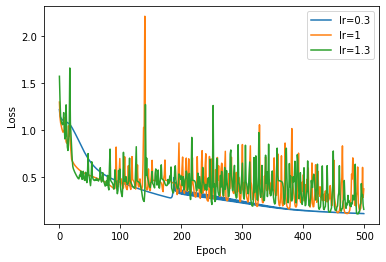

In [52]:
for lr, run in zip(lrs, all_losses):
    plt.plot(run, label='lr={}'.format(lr))
    plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [53]:
# !wget -c http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
# !wget -c http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
# !wget -c http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
# !wget -c http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

In [54]:
# !gunzip --keep *.gz

In [55]:
from mlxtend.data import loadlocal_mnist

In [56]:
x_train, y_train = loadlocal_mnist(
        images_path='train-images-idx3-ubyte', 
        labels_path='train-labels-idx1-ubyte')


In [57]:
print('Dimensions: %s x %s' % (x_train.shape[0], x_train.shape[1]))

Dimensions: 60000 x 784


In [58]:
x_train = x_train.astype('float')
y_train = y_train.astype('float')

In [59]:
x_test, y_test = loadlocal_mnist(
        images_path='t10k-images-idx3-ubyte', 
        labels_path='t10k-labels-idx1-ubyte')


In [60]:
x_test = x_test.astype('float')
y_test = y_test.astype('float')

In [61]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = (1.0/6.0), random_state = 42)
sss.get_n_splits(x_train, y_train)
train_idx, valid_idx = next(sss.split(x_train, y_train))

In [62]:
len(train_idx), len(valid_idx)

(50000, 10000)

In [63]:
x_train, y_train, x_val, y_val = x_train[train_idx], y_train[train_idx], x_train[valid_idx], y_train[valid_idx]

In [64]:
onehotencode = lambda i: np.eye(10)[int(i)]
y_train_one_hot = np.asarray([onehotencode(i) for i in y_train])
y_val_one_hot = np.asarray([onehotencode(i) for i in y_val])
y_test_one_hot = np.asarray([onehotencode(i) for i in y_test])

In [65]:
# Normalize inputs. Calculate mean and standard deviation on only training data, then apply on test too.
train_mean = np.mean(x_train)
std = np.std(x_train)
print(train_mean, std)

x_train = (x_train - train_mean) / (std)
x_val = (x_val - train_mean) / (std)
x_test = (x_test - train_mean) / (std)

33.346894719387755 78.5983434401015


In [66]:
print(np.mean(x_train), np.std(x_train))
print(np.mean(x_val), np.std(x_val))
print(np.mean(x_test), np.std(x_test))

-8.982420249780336e-17 1.0000000000000007
-0.0021735778372624355 0.997640434643637
0.005653169659316968 1.0073044768764425


In [67]:
# layers_mnist = [
#                 FullyConnected(16, 784),
#                 Sigmoid(),
#                 FullyConnected(10, 16),
#               ]
layers_mnist = [
                FullyConnected(16, 784),
                Tanh(),
                FullyConnected(10, 16),
              ]
mymlp_mnist = MultiLayerPerceptron(layers_mnist, SoftmaxCrossEntropyLoss(), SoftmaxLayer())

In [68]:
del mymlp_iris

In [69]:
best_mlp_mnist = None
best_f1 = 0.0
losses = []
for epoch in range(100):
    mymlp_mnist.train_mode()
    _, loss = mymlp_mnist.forward(x_train, y_train_one_hot)
    mymlp_mnist.backward()

    train_acc, train_prec, train_rec, train_f1 = tester(mymlp_mnist, x_train, y_train_one_hot)
    print("Epoch {} train_acc: {}, train_prec: {}, train_rec: {}, train_f1: {}".format(epoch, train_acc, train_prec, train_rec, train_f1))

    val_acc, val_prec, val_rec, val_f1 = tester(mymlp_mnist, x_val, y_val_one_hot)
    print("Epoch {} val_acc: {}, val_prec: {}, val_rec: {}, val_f1: {}".format(epoch, val_acc, val_prec, val_rec, val_f1))

    test_acc, test_prec, test_rec, test_f1 = tester(mymlp_mnist, x_test, y_test_one_hot)
    print("Epoch {} test_acc: {}, test_prec: {}, test_rec: {}, test_f1: {}".format(epoch, test_acc, test_prec, test_rec, test_f1))

    if  val_f1 > best_f1:
        best_mlp_mnist = deepcopy(mymlp_mnist)
        best_f1 = val_f1
        print("Saving as best model...")
    print(mymlp_mnist.optimize(1.0))
    print('Loss',loss)
    losses.append(loss)

Fully Connected Layer ID = 16: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 0 (50000, 16), (50000, 16)
Fully Connected Layer ID = 17: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 0 train_acc: 0.11438, train_prec: 0.12431684856132438, train_rec: 0.11438, train_f1: 0.1114365505162071
Epoch 0 val_acc: 0.1121, val_prec: 0.12238859920898373, val_rec: 0.1121, val_f1: 0.1090254862836668
Epoch 0 test_acc: 0.1156, test_prec: 0.12982482896503006, test_rec: 0.1156, test_f1: 0.11319328597319896
Saving as best model...
46.41628763325906
5.779742777416126
False
Loss 2.827256512361163
Fully Connected Layer ID = 16: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 0 (50000, 16), (50000, 16)
Fully Connected Layer ID = 17: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 1 train_acc: 0.23974, train_prec: 0.2142780402610697, train_rec: 0.23974, train_f1: 0.22060640193238185
Epoch 1 val_acc: 0.2328, val_prec: 0.20739686980529282, val_rec: 0.2328, val_f1: 0.21406739007392517
Epoch 1

Epoch 14 train_acc: 0.7187, train_prec: 0.71181067101828, train_rec: 0.7187, train_f1: 0.7114101086386875
Epoch 14 val_acc: 0.7156, val_prec: 0.7095504590441752, val_rec: 0.7156, val_f1: 0.7083370876800306
Epoch 14 test_acc: 0.726, test_prec: 0.7197727048850765, test_rec: 0.726, test_f1: 0.7199411989799506
Saving as best model...
9.005077493569694
1.0540063774563895
False
Loss 0.9170506463669366
Fully Connected Layer ID = 16: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 0 (50000, 16), (50000, 16)
Fully Connected Layer ID = 17: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 15 train_acc: 0.7268, train_prec: 0.720170119061104, train_rec: 0.7268, train_f1: 0.7199640070230935
Epoch 15 val_acc: 0.7247, val_prec: 0.7188646108750965, val_rec: 0.7247, val_f1: 0.7179031936194554
Epoch 15 test_acc: 0.7342, test_prec: 0.7283692737243364, test_rec: 0.7342, test_f1: 0.7284537316854729
Saving as best model...
8.592578124926284
0.9989096067031153
False
Loss 0.8912039391778647
Fully Conn

Epoch 28 val_acc: 0.7873, val_prec: 0.783885453437648, val_rec: 0.7873, val_f1: 0.7841708977611814
Epoch 28 test_acc: 0.7988, test_prec: 0.7961032942336905, test_rec: 0.7988, test_f1: 0.7960023903254159
Saving as best model...
5.873115128999805
0.6164613848195737
False
Loss 0.6856865766168669
Fully Connected Layer ID = 16: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 0 (50000, 16), (50000, 16)
Fully Connected Layer ID = 17: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 29 train_acc: 0.79616, train_prec: 0.7925958685714876, train_rec: 0.79616, train_f1: 0.7930360829767781
Epoch 29 val_acc: 0.791, val_prec: 0.787766525977235, val_rec: 0.791, val_f1: 0.7880173705785103
Epoch 29 test_acc: 0.8021, test_prec: 0.7995730455505452, test_rec: 0.8021, test_f1: 0.799476593682496
Saving as best model...
5.7456165468573275
0.5999161466041215
False
Loss 0.6754609117446563
Fully Connected Layer ID = 16: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 0 (50000, 16), (50000, 16

Epoch 43 train_acc: 0.83002, train_prec: 0.8278530306455577, train_rec: 0.83002, train_f1: 0.8282230280286837
Epoch 43 val_acc: 0.8259, val_prec: 0.8241965537642904, val_rec: 0.8259, val_f1: 0.8242393690810684
Epoch 43 test_acc: 0.8325, test_prec: 0.8311838918734217, test_rec: 0.8325, test_f1: 0.8310031094875919
Saving as best model...
4.544163273091969
0.4235033931195013
False
Loss 0.57023216104902
Fully Connected Layer ID = 16: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 0 (50000, 16), (50000, 16)
Fully Connected Layer ID = 17: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 44 train_acc: 0.83148, train_prec: 0.8293878389643009, train_rec: 0.83148, train_f1: 0.829751863222791
Epoch 44 val_acc: 0.8274, val_prec: 0.8257665458698273, val_rec: 0.8274, val_f1: 0.8258026118789421
Epoch 44 test_acc: 0.8341, test_prec: 0.8327969744548774, test_rec: 0.8341, test_f1: 0.8326215679830841
Saving as best model...
4.4882978816642325
0.41430028291790927
False
Loss 0.5646206773400928
Fu

Epoch 57 val_acc: 0.8467, val_prec: 0.8458313714106876, val_rec: 0.8467, val_f1: 0.8458689651070052
Epoch 57 test_acc: 0.8511, test_prec: 0.850292782348873, test_rec: 0.8511, test_f1: 0.8501059382411157
Saving as best model...
3.791482141231406
0.3231367881377092
False
Loss 0.5063630478211305
Fully Connected Layer ID = 16: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 0 (50000, 16), (50000, 16)
Fully Connected Layer ID = 17: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 58 train_acc: 0.85162, train_prec: 0.8502512866704863, train_rec: 0.85162, train_f1: 0.8505563522176599
Epoch 58 val_acc: 0.848, val_prec: 0.847177205838171, val_rec: 0.848, val_f1: 0.8472195305387684
Epoch 58 test_acc: 0.8521, test_prec: 0.8513192646014475, test_rec: 0.8521, test_f1: 0.8511579692938929
Saving as best model...
3.7485362730066405
0.31784300069989085
False
Loss 0.502773825061132
Fully Connected Layer ID = 16: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 0 (50000, 16), (50000, 1

Epoch 71 train_acc: 0.86306, train_prec: 0.8620309617885646, train_rec: 0.86306, train_f1: 0.8622764647767752
Epoch 71 val_acc: 0.8595, val_prec: 0.8590705883638314, val_rec: 0.8595, val_f1: 0.859052858009893
Epoch 71 test_acc: 0.8632, test_prec: 0.8627324535633426, test_rec: 0.8632, test_f1: 0.8625408012600088
Saving as best model...
3.271768664975095
0.25985619648612235
False
Loss 0.4637639187578181
Fully Connected Layer ID = 16: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 0 (50000, 16), (50000, 16)
Fully Connected Layer ID = 17: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 72 train_acc: 0.86388, train_prec: 0.8628846888392846, train_rec: 0.86388, train_f1: 0.8631203777040148
Epoch 72 val_acc: 0.8601, val_prec: 0.8596772738059845, val_rec: 0.8601, val_f1: 0.8596515998265774
Epoch 72 test_acc: 0.8641, test_prec: 0.8637011222140449, test_rec: 0.8641, test_f1: 0.8634947109898565
Saving as best model...
3.236468298337511
0.2561326541775715
False
Loss 0.46125588379862004


Epoch 85 val_acc: 0.8669, val_prec: 0.8666021622630169, val_rec: 0.8669, val_f1: 0.8665554379024101
Epoch 85 test_acc: 0.8719, test_prec: 0.8716297550284698, test_rec: 0.8719, test_f1: 0.8714702952991713
Saving as best model...
2.8514449192456275
0.2157075986723182
False
Loss 0.43339471763159704
Fully Connected Layer ID = 16: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 0 (50000, 16), (50000, 16)
Fully Connected Layer ID = 17: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 86 train_acc: 0.87282, train_prec: 0.8720321480350935, train_rec: 0.87282, train_f1: 0.8722216393587873
Epoch 86 val_acc: 0.867, val_prec: 0.8667381756503788, val_rec: 0.867, val_f1: 0.8666658579826546
Epoch 86 test_acc: 0.8723, test_prec: 0.8720435436963029, test_rec: 0.8723, test_f1: 0.8718709938762506
Saving as best model...
2.829518717009532
0.213163355205424
False
Loss 0.4315331533647485
Fully Connected Layer ID = 16: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 0 (50000, 16), (50000,

In [70]:
test_acc, test_prec, test_rec, test_f1 = tester(best_mlp_mnist, x_test, y_test_one_hot)
print("TEST: test_acc: {}, test_prec: {}, test_rec: {}, test_f1: {}".format(test_acc, test_prec, test_rec, test_f1))

TEST: test_acc: 0.8787, test_prec: 0.8785662154034635, test_rec: 0.8787, test_f1: 0.8783830263814411


In [71]:
mymlp_mnist.all_outputs

[]

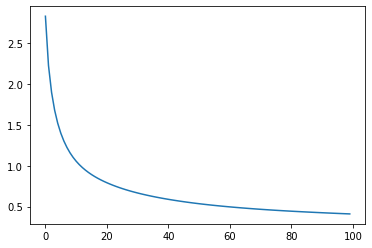

In [72]:
plt.plot(losses)
plt.show()

In [73]:
lrs = [0.7, 1., 1.3]
all_losses = []

for lr in lrs:
    layers_mnist = [
                    FullyConnected(16, 784),
                    Tanh(),
                    FullyConnected(10, 16),
                  ]
    mymlp_mnist = MultiLayerPerceptron(layers_mnist, SoftmaxCrossEntropyLoss(), SoftmaxLayer())

    best_mlp_mnist = None
    best_f1 = 0.0
    losses = []
    for epoch in range(100):
        mymlp_mnist.train_mode()
        _, loss = mymlp_mnist.forward(x_train, y_train_one_hot)
        mymlp_mnist.backward()

        train_acc, train_prec, train_rec, train_f1 = tester(mymlp_mnist, x_train, y_train_one_hot)
        print("Epoch {} train_acc: {}, train_prec: {}, train_rec: {}, train_f1: {}".format(epoch, train_acc, train_prec, train_rec, train_f1))

        val_acc, val_prec, val_rec, val_f1 = tester(mymlp_mnist, x_val, y_val_one_hot)
        print("Epoch {} val_acc: {}, val_prec: {}, val_rec: {}, val_f1: {}".format(epoch, val_acc, val_prec, val_rec, val_f1))

        test_acc, test_prec, test_rec, test_f1 = tester(mymlp_mnist, x_test, y_test_one_hot)
        print("Epoch {} test_acc: {}, test_prec: {}, test_rec: {}, test_f1: {}".format(epoch, test_acc, test_prec, test_rec, test_f1))

        if  val_f1 > best_f1:
            best_mlp_mnist = deepcopy(mymlp_mnist)
            best_f1 = val_f1
            print("Saving as best model...")
        print(mymlp_mnist.optimize(lr))
        print('Loss',loss)
        losses.append(loss)
    all_losses.append(losses)

Fully Connected Layer ID = 18: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 1 (50000, 16), (50000, 16)
Fully Connected Layer ID = 19: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 0 train_acc: 0.09008, train_prec: 0.08798471311575351, train_rec: 0.09008, train_f1: 0.0786559291590926
Epoch 0 val_acc: 0.0908, val_prec: 0.08768137666614614, val_rec: 0.0908, val_f1: 0.07905706030765046
Epoch 0 test_acc: 0.0934, test_prec: 0.08814711424113589, test_rec: 0.0934, test_f1: 0.07805900853721573
Saving as best model...
46.857285973193505
6.658089100551517
False
Loss 2.937521099767827
Fully Connected Layer ID = 18: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 1 (50000, 16), (50000, 16)
Fully Connected Layer ID = 19: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 1 train_acc: 0.14644, train_prec: 0.14874761353054783, train_rec: 0.14644, train_f1: 0.14221718158991048
Epoch 1 val_acc: 0.1474, val_prec: 0.15144272088076322, val_rec: 0.1474, val_f1: 0.14407016194137287
Epoc

Epoch 14 val_acc: 0.6635, val_prec: 0.6575423581102962, val_rec: 0.6635, val_f1: 0.6520946901384564
Epoch 14 test_acc: 0.6742, test_prec: 0.667917940840407, test_rec: 0.6742, test_f1: 0.6643752311186769
Saving as best model...
11.999044334885339
1.4532834210901857
False
Loss 1.1112785486636378
Fully Connected Layer ID = 18: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 1 (50000, 16), (50000, 16)
Fully Connected Layer ID = 19: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 15 train_acc: 0.6759, train_prec: 0.6682553692110047, train_rec: 0.6759, train_f1: 0.6659587659870282
Epoch 15 val_acc: 0.6749, val_prec: 0.6693239801956994, val_rec: 0.6749, val_f1: 0.664391275857439
Epoch 15 test_acc: 0.6856, test_prec: 0.6800168834357865, test_rec: 0.6856, test_f1: 0.676835002999741
Saving as best model...
11.543467719626893
1.3914883128425142
False
Loss 1.0774861765247752
Fully Connected Layer ID = 18: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 1 (50000, 16), (50000, 1

Tanh Layer ID = 1 (50000, 16), (50000, 16)
Fully Connected Layer ID = 19: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 29 train_acc: 0.76412, train_prec: 0.7604662767156413, train_rec: 0.76412, train_f1: 0.760246094719177
Epoch 29 val_acc: 0.7609, val_prec: 0.7577804459494651, val_rec: 0.7609, val_f1: 0.7568823755682955
Epoch 29 test_acc: 0.7744, test_prec: 0.7716337270729803, test_rec: 0.7744, test_f1: 0.770801057844749
Saving as best model...
7.8049843796897065
0.8381908198847621
False
Loss 0.7929914256198737
Fully Connected Layer ID = 18: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 1 (50000, 16), (50000, 16)
Fully Connected Layer ID = 19: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 30 train_acc: 0.76776, train_prec: 0.7643202480841, train_rec: 0.76776, train_f1: 0.7641563790124241
Epoch 30 val_acc: 0.7646, val_prec: 0.7614471978141625, val_rec: 0.7646, val_f1: 0.7607728781728237
Epoch 30 test_acc: 0.7789, test_prec: 0.7764009654174385, test_rec: 0.7789, test_f1: 

Epoch 43 train_acc: 0.80466, train_prec: 0.8024362082418283, train_rec: 0.80466, train_f1: 0.8026876723655051
Epoch 43 val_acc: 0.7982, val_prec: 0.7959802358160029, val_rec: 0.7982, val_f1: 0.7961318692843015
Epoch 43 test_acc: 0.8164, test_prec: 0.814696497320811, test_rec: 0.8164, test_f1: 0.8145434421225736
Saving as best model...
6.0394338192836745
0.5908116259597352
False
Loss 0.6597877871841707
Fully Connected Layer ID = 18: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 1 (50000, 16), (50000, 16)
Fully Connected Layer ID = 19: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 44 train_acc: 0.80682, train_prec: 0.8046360286869173, train_rec: 0.80682, train_f1: 0.8049004440642052
Epoch 44 val_acc: 0.8008, val_prec: 0.7986500545917243, val_rec: 0.8008, val_f1: 0.7988323903185232
Epoch 44 test_acc: 0.8181, test_prec: 0.8164935472649382, test_rec: 0.8181, test_f1: 0.8163230197661279
Saving as best model...
5.946476919190372
0.5788330535473487
False
Loss 0.6528644516814631
F

Epoch 57 train_acc: 0.82758, train_prec: 0.8259426032222781, train_rec: 0.82758, train_f1: 0.8261833026871794
Epoch 57 val_acc: 0.8224, val_prec: 0.8207530322719747, val_rec: 0.8224, val_f1: 0.8209223622018406
Epoch 57 test_acc: 0.8389, test_prec: 0.8378912489735174, test_rec: 0.8389, test_f1: 0.8377450423775277
Saving as best model...
4.943090841516938
0.45579196078124196
False
Loss 0.5812310437291103
Fully Connected Layer ID = 18: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 1 (50000, 16), (50000, 16)
Fully Connected Layer ID = 19: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 58 train_acc: 0.82892, train_prec: 0.8273048410020786, train_rec: 0.82892, train_f1: 0.8275599130764757
Epoch 58 val_acc: 0.8234, val_prec: 0.8217438001192131, val_rec: 0.8234, val_f1: 0.8219640721275502
Epoch 58 test_acc: 0.8402, test_prec: 0.8391604942229185, test_rec: 0.8402, test_f1: 0.8390219477320947
Saving as best model...
4.8804501070988024
0.44823593093548353
False
Loss 0.576825354590025

Saving as best model...
4.251152636811292
0.36622336337028055
False
Loss 0.5287167887879555
Fully Connected Layer ID = 18: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 1 (50000, 16), (50000, 16)
Fully Connected Layer ID = 19: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 72 train_acc: 0.84494, train_prec: 0.8437237191592675, train_rec: 0.84494, train_f1: 0.8439511207975449
Epoch 72 val_acc: 0.8406, val_prec: 0.8395427078144827, val_rec: 0.8406, val_f1: 0.8396330229620693
Epoch 72 test_acc: 0.8527, test_prec: 0.8518047414305498, test_rec: 0.8527, test_f1: 0.8517305663718262
Saving as best model...
4.2113905754517225
0.360956418487921
False
Loss 0.5255869162697762
Fully Connected Layer ID = 18: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 1 (50000, 16), (50000, 16)
Fully Connected Layer ID = 19: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 73 train_acc: 0.84602, train_prec: 0.8448322995949715, train_rec: 0.84602, train_f1: 0.845056285397136
Epoch 73 val_acc

Epoch 86 train_acc: 0.85562, train_prec: 0.8546352836211878, train_rec: 0.85562, train_f1: 0.8548269157509538
Epoch 86 val_acc: 0.8512, val_prec: 0.8502504448119426, val_rec: 0.8512, val_f1: 0.8503933310883216
Epoch 86 test_acc: 0.8624, test_prec: 0.8617019927606738, test_rec: 0.8624, test_f1: 0.8616349922138578
Saving as best model...
3.695982477101071
0.3022257905799757
False
Loss 0.48812598716029104
Fully Connected Layer ID = 18: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 1 (50000, 16), (50000, 16)
Fully Connected Layer ID = 19: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 87 train_acc: 0.8562, train_prec: 0.8552254767449523, train_rec: 0.8562, train_f1: 0.8554165359533846
Epoch 87 val_acc: 0.8514, val_prec: 0.8504694696840317, val_rec: 0.8514, val_f1: 0.8506238083005221
Epoch 87 test_acc: 0.8636, test_prec: 0.8629435247593392, test_rec: 0.8636, test_f1: 0.8628688996257184
Saving as best model...
3.6626685721060332
0.2987650564681344
False
Loss 0.4858382512661245
F

Epoch 0 train_acc: 0.105, train_prec: 0.10584677617375018, train_rec: 0.105, train_f1: 0.09624165389664514
Epoch 0 val_acc: 0.1075, val_prec: 0.10678373407436623, val_rec: 0.1075, val_f1: 0.09813778863658754
Epoch 0 test_acc: 0.0986, test_prec: 0.10353091317958583, test_rec: 0.0986, test_f1: 0.09108560588158107
Saving as best model...
42.24910371091636
5.331701928243742
False
Loss 2.7444436033323547
Fully Connected Layer ID = 20: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 2 (50000, 16), (50000, 16)
Fully Connected Layer ID = 21: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 1 train_acc: 0.24406, train_prec: 0.23182431500166276, train_rec: 0.24406, train_f1: 0.22686477081146858
Epoch 1 val_acc: 0.2448, val_prec: 0.23332729912400463, val_rec: 0.2448, val_f1: 0.22909213233513465
Epoch 1 test_acc: 0.2379, test_prec: 0.2285197732022916, test_rec: 0.2379, test_f1: 0.22245113536220232
Saving as best model...
27.298877134278424
3.645333469084205
False
Loss 2.252807670955133
Fu

Epoch 14 train_acc: 0.67312, train_prec: 0.6647438062111672, train_rec: 0.67312, train_f1: 0.6636685693953551
Epoch 14 val_acc: 0.6687, val_prec: 0.6621785178548415, val_rec: 0.6687, val_f1: 0.6603169640298174
Epoch 14 test_acc: 0.6703, test_prec: 0.663288021691463, test_rec: 0.6703, test_f1: 0.6614341835262241
Saving as best model...
10.084182064081787
1.16537594172057
False
Loss 1.0474056277048884
Fully Connected Layer ID = 20: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 2 (50000, 16), (50000, 16)
Fully Connected Layer ID = 21: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 15 train_acc: 0.68356, train_prec: 0.6761392555341331, train_rec: 0.68356, train_f1: 0.6751818522675469
Epoch 15 val_acc: 0.6788, val_prec: 0.6730631603687757, val_rec: 0.6788, val_f1: 0.6717948366580753
Epoch 15 test_acc: 0.6833, test_prec: 0.6772843982289042, test_rec: 0.6833, test_f1: 0.6759574637973648
Saving as best model...
9.674139249502383
1.116258586868002
False
Loss 1.0141794710056578
Full

Epoch 28 train_acc: 0.77032, train_prec: 0.7678828826585461, train_rec: 0.77032, train_f1: 0.7682267332966629
Epoch 28 val_acc: 0.7654, val_prec: 0.7635544607371207, val_rec: 0.7654, val_f1: 0.7633418083476269
Epoch 28 test_acc: 0.7747, test_prec: 0.7730576126461955, test_rec: 0.7747, test_f1: 0.7727806770048857
Saving as best model...
6.5807096455821785
0.6874413614871069
False
Loss 0.7457642114554901
Fully Connected Layer ID = 20: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 2 (50000, 16), (50000, 16)
Fully Connected Layer ID = 21: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 29 train_acc: 0.775, train_prec: 0.7726303256941611, train_rec: 0.775, train_f1: 0.7729774648826336
Epoch 29 val_acc: 0.7702, val_prec: 0.7683144039404038, val_rec: 0.7702, val_f1: 0.7681904573625221
Epoch 29 test_acc: 0.7795, test_prec: 0.7780388495534748, test_rec: 0.7795, test_f1: 0.7776846146316685
Saving as best model...
6.450211074732798
0.6652819018207198
False
Loss 0.7327875855343341
Full

Epoch 42 train_acc: 0.81534, train_prec: 0.8139381663502124, train_rec: 0.81534, train_f1: 0.8141647833239533
Epoch 42 val_acc: 0.8101, val_prec: 0.8090881680370107, val_rec: 0.8101, val_f1: 0.8089621695251572
Epoch 42 test_acc: 0.8179, test_prec: 0.8171476756553906, test_rec: 0.8179, test_f1: 0.8167731222838104
Saving as best model...
5.020925284180797
0.4574063185768008
False
Loss 0.6085031585033258
Fully Connected Layer ID = 20: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 2 (50000, 16), (50000, 16)
Fully Connected Layer ID = 21: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 43 train_acc: 0.81734, train_prec: 0.8159815926929904, train_rec: 0.81734, train_f1: 0.8162013549907701
Epoch 43 val_acc: 0.8131, val_prec: 0.8121202419090335, val_rec: 0.8131, val_f1: 0.811998195595962
Epoch 43 test_acc: 0.82, test_prec: 0.819238357965719, test_rec: 0.82, test_f1: 0.8189490680409112
Saving as best model...
4.930416617287122
0.4458246680336043
False
Loss 0.6015886878880295
Fully C

Epoch 56 train_acc: 0.84004, train_prec: 0.839149042654034, train_rec: 0.84004, train_f1: 0.8392683241965885
Epoch 56 val_acc: 0.8352, val_prec: 0.8344953436853076, val_rec: 0.8352, val_f1: 0.8343658090678253
Epoch 56 test_acc: 0.8426, test_prec: 0.8422610714105997, test_rec: 0.8426, test_f1: 0.841878687525227
Saving as best model...
4.027429319227558
0.33138108866562577
False
Loss 0.5327043871774012
Fully Connected Layer ID = 20: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 2 (50000, 16), (50000, 16)
Fully Connected Layer ID = 21: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 57 train_acc: 0.84118, train_prec: 0.8403300403387264, train_rec: 0.84118, train_f1: 0.8404334361287059
Epoch 57 val_acc: 0.836, val_prec: 0.835342803248772, val_rec: 0.836, val_f1: 0.8351794102748494
Epoch 57 test_acc: 0.8436, test_prec: 0.8433152626944955, test_rec: 0.8436, test_f1: 0.8429275095697252
Saving as best model...
3.9704309712466204
0.32499092580967354
False
Loss 0.5286241946903248
Ful

Epoch 70 train_acc: 0.85494, train_prec: 0.8542555303558648, train_rec: 0.85494, train_f1: 0.8543612716463582
Epoch 70 val_acc: 0.8472, val_prec: 0.8465834637409775, val_rec: 0.8472, val_f1: 0.8465646131799953
Epoch 70 test_acc: 0.8551, test_prec: 0.8547940780006679, test_rec: 0.8551, test_f1: 0.8545234034409981
Saving as best model...
3.390619573372332
0.2587249343542084
False
Loss 0.4855519607396099
Fully Connected Layer ID = 20: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 2 (50000, 16), (50000, 16)
Fully Connected Layer ID = 21: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 71 train_acc: 0.85582, train_prec: 0.8551120433018662, train_rec: 0.85582, train_f1: 0.8552324629399798
Epoch 71 val_acc: 0.8486, val_prec: 0.84801768633923, val_rec: 0.8486, val_f1: 0.8479750625477913
Epoch 71 test_acc: 0.8561, test_prec: 0.8558144146929019, test_rec: 0.8561, test_f1: 0.8555497546758813
Saving as best model...
3.3547432129675507
0.2546843762737017
False
Loss 0.48283734801437284
F

Epoch 84 train_acc: 0.86532, train_prec: 0.8647040208029125, train_rec: 0.86532, train_f1: 0.8647946930496176
Epoch 84 val_acc: 0.857, val_prec: 0.8564271906408291, val_rec: 0.857, val_f1: 0.8564422537212999
Epoch 84 test_acc: 0.8654, test_prec: 0.8651763594766637, test_rec: 0.8654, test_f1: 0.8648992832626639
Saving as best model...
2.9577724433248207
0.21113184149457195
False
Loss 0.45267604661083016
Fully Connected Layer ID = 20: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 2 (50000, 16), (50000, 16)
Fully Connected Layer ID = 21: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 85 train_acc: 0.8659, train_prec: 0.8652952122843642, train_rec: 0.8659, train_f1: 0.865385702311879
Epoch 85 val_acc: 0.8571, val_prec: 0.8565180378793202, val_rec: 0.8571, val_f1: 0.8565327004506195
Epoch 85 test_acc: 0.8658, test_prec: 0.8655767848289486, test_rec: 0.8658, test_f1: 0.8653057666246826
Saving as best model...
2.9333299281425473
0.20846474159845033
False
Loss 0.4506709743426079
F

Epoch 98 train_acc: 0.87236, train_prec: 0.8718252733997365, train_rec: 0.87236, train_f1: 0.8719045168690779
Epoch 98 val_acc: 0.864, val_prec: 0.8634622874584776, val_rec: 0.864, val_f1: 0.8634988193423835
Epoch 98 test_acc: 0.8712, test_prec: 0.871117606056823, test_rec: 0.8712, test_f1: 0.8708240236984904
Saving as best model...
2.666602305855906
0.18133584499284353
False
Loss 0.4272754952621864
Fully Connected Layer ID = 20: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 2 (50000, 16), (50000, 16)
Fully Connected Layer ID = 21: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 99 train_acc: 0.873, train_prec: 0.8724665839578739, train_rec: 0.873, train_f1: 0.8725504847912604
Epoch 99 val_acc: 0.8646, val_prec: 0.8640597071464308, val_rec: 0.8646, val_f1: 0.8641031809934079
Epoch 99 test_acc: 0.8712, test_prec: 0.8711244017042085, test_rec: 0.8712, test_f1: 0.8708309531141882
Saving as best model...
2.64633800970813
0.17968022577224857
False
Loss 0.4256550206915752
Fully C

Fully Connected Layer ID = 22: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 3 (50000, 16), (50000, 16)
Fully Connected Layer ID = 23: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 13 train_acc: 0.71618, train_prec: 0.710733054997022, train_rec: 0.71618, train_f1: 0.7109466623173506
Epoch 13 val_acc: 0.7021, val_prec: 0.6969385567772916, val_rec: 0.7021, val_f1: 0.6962193431911996
Epoch 13 test_acc: 0.7189, test_prec: 0.7143930963728841, test_rec: 0.7189, test_f1: 0.714464460386016
Saving as best model...
9.503160587648338
1.1205720783844637
False
Loss 0.9493107891358006
Fully Connected Layer ID = 22: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 3 (50000, 16), (50000, 16)
Fully Connected Layer ID = 23: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 14 train_acc: 0.72758, train_prec: 0.7228287880508794, train_rec: 0.72758, train_f1: 0.7229286094788898
Epoch 14 val_acc: 0.7131, val_prec: 0.7085173393696947, val_rec: 0.7131, val_f1: 0.7078626900625286
Epoch 14 

Epoch 27 test_acc: 0.8094, test_prec: 0.8075368719169481, test_rec: 0.8094, test_f1: 0.8078640757073603
Saving as best model...
5.727383979370607
0.5201403583725592
False
Loss 0.6514898389698917
Fully Connected Layer ID = 22: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 3 (50000, 16), (50000, 16)
Fully Connected Layer ID = 23: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 28 train_acc: 0.80808, train_prec: 0.8060365430248095, train_rec: 0.80808, train_f1: 0.8065019567960758
Epoch 28 val_acc: 0.7976, val_prec: 0.7954473760122784, val_rec: 0.7976, val_f1: 0.795644087651554
Epoch 28 test_acc: 0.8139, test_prec: 0.8121466141921497, test_rec: 0.8139, test_f1: 0.8124424505474585
Saving as best model...
5.559960809407428
0.5014977265213593
False
Loss 0.6403100372126556
Fully Connected Layer ID = 22: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 3 (50000, 16), (50000, 16)
Fully Connected Layer ID = 23: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 29 train_acc: 0.8

Fully Connected Layer ID = 23: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 42 train_acc: 0.84122, train_prec: 0.83995063049925, train_rec: 0.84122, train_f1: 0.840303981755526
Epoch 42 val_acc: 0.8328, val_prec: 0.8314223375256669, val_rec: 0.8328, val_f1: 0.8317511547794931
Epoch 42 test_acc: 0.8455, test_prec: 0.844373081283015, test_rec: 0.8455, test_f1: 0.8445739009362838
Saving as best model...
4.032301823087542
0.33303909312773733
False
Loss 0.5336707412021808
Fully Connected Layer ID = 22: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 3 (50000, 16), (50000, 16)
Fully Connected Layer ID = 23: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 43 train_acc: 0.84272, train_prec: 0.8415058553992627, train_rec: 0.84272, train_f1: 0.8418600557565978
Epoch 43 val_acc: 0.834, val_prec: 0.8325743140450601, val_rec: 0.834, val_f1: 0.8329127722092742
Epoch 43 test_acc: 0.8473, test_prec: 0.8461544775756847, test_rec: 0.8473, test_f1: 0.8463663428284636
Saving as best model...
3

Epoch 56 test_acc: 0.8603, test_prec: 0.8594421341153778, test_rec: 0.8603, test_f1: 0.8596744796125573
Saving as best model...
3.2306757344858177
0.245926209074758
False
Loss 0.47551889226653116
Fully Connected Layer ID = 22: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 3 (50000, 16), (50000, 16)
Fully Connected Layer ID = 23: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 57 train_acc: 0.86072, train_prec: 0.8599122136931414, train_rec: 0.86072, train_f1: 0.8601535652229427
Epoch 57 val_acc: 0.852, val_prec: 0.8509299055120464, val_rec: 0.852, val_f1: 0.8512502592744798
Epoch 57 test_acc: 0.8611, test_prec: 0.860287963622617, test_rec: 0.8611, test_f1: 0.860518111166702
Saving as best model...
3.1896440138797635
0.241135405386624
False
Loss 0.4723189443045401
Fully Connected Layer ID = 22: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 3 (50000, 16), (50000, 16)
Fully Connected Layer ID = 23: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 58 train_acc: 0.861

Epoch 71 train_acc: 0.87186, train_prec: 0.8712575383992116, train_rec: 0.87186, train_f1: 0.8714480338104957
Epoch 71 val_acc: 0.8622, val_prec: 0.8614614316696819, val_rec: 0.8622, val_f1: 0.8617049140453364
Epoch 71 test_acc: 0.873, test_prec: 0.872322032803554, test_rec: 0.873, test_f1: 0.8725305929065785
Saving as best model...
2.744655653723887
0.19196063972540311
False
Loss 0.4356188946485256
Fully Connected Layer ID = 22: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 3 (50000, 16), (50000, 16)
Fully Connected Layer ID = 23: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 72 train_acc: 0.87246, train_prec: 0.8718729697635272, train_rec: 0.87246, train_f1: 0.872059310168403
Epoch 72 val_acc: 0.8624, val_prec: 0.8616522124274252, val_rec: 0.8624, val_f1: 0.8618963064604354
Epoch 72 test_acc: 0.8733, test_prec: 0.8726356416219789, test_rec: 0.8733, test_f1: 0.8728414850512068
Saving as best model...
2.7186659202150927
0.18934605960462594
False
Loss 0.43344901188017776
F

Epoch 85 train_acc: 0.8799, train_prec: 0.8793960778830292, train_rec: 0.8799, train_f1: 0.879554474025143
Epoch 85 val_acc: 0.8707, val_prec: 0.8701391224744077, val_rec: 0.8707, val_f1: 0.8703098545704293
Epoch 85 test_acc: 0.8788, test_prec: 0.8782177284376106, test_rec: 0.8788, test_f1: 0.8783765252338837
Saving as best model...
2.4379872241103975
0.16212955894421052
False
Loss 0.4089789288722939
Fully Connected Layer ID = 22: (In:784, Out:16) (50000, 784), (50000, 16)
Tanh Layer ID = 3 (50000, 16), (50000, 16)
Fully Connected Layer ID = 23: (In:16, Out:10) (50000, 16), (50000, 10)
Epoch 86 train_acc: 0.8802, train_prec: 0.8797073647065526, train_rec: 0.8802, train_f1: 0.8798614300561938
Epoch 86 val_acc: 0.8711, val_prec: 0.8705489631341538, val_rec: 0.8711, val_f1: 0.8707138556191357
Epoch 86 test_acc: 0.8794, test_prec: 0.8788462886928812, test_rec: 0.8794, test_f1: 0.8790047903828428
Saving as best model...
2.4197555073707258
0.1604250148631834
False
Loss 0.40733187473693155
Fu

Epoch 99 test_acc: 0.8847, test_prec: 0.8842605442142701, test_rec: 0.8847, test_f1: 0.8844054809281704
Saving as best model...
2.2092270373644904
0.14264762930158942
False
Loss 0.3880652339896019


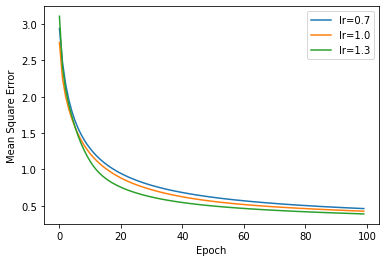

In [74]:
for lr, run in zip(lrs, all_losses):
    plt.plot(run, label='lr={}'.format(lr))
    plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.show()